# **Road Risk Analysis: Supervised & Unsupervised Learning**

### Nofar Mahrabi - 315153726
### Rotem Barel   - 318223872

In [1]:
import math
import pickle
import numpy as np
import pandas as pd
import requests
from datetime import datetime
from collections import defaultdict
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy import stats
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

from sklearn.metrics import (
    mean_squared_error,
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,)

from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# **End-to-End Classification Pipeline**

### **Function in use**

In [2]:
def describe_dataframe(df, num_rows=5):
    print("==== DataFrame Head ====")
    display(df.head(num_rows))
    
    print("\n==== DataFrame Info ====")
    df.info()
    
    print("\n==== DataFrame Description (Numeric Columns) ====")
    display(df.describe().transpose())
    
    print("\n==== DataFrame Description (Categorical Columns) ====")
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    if not categorical_columns.empty:
        display(df[categorical_columns].describe().transpose())
    else:
        print("No categorical columns found.")

### CODE BY GPT### 
def plot_boxplot_matrix(df, columns, n_cols=3, figsize=(15, 4), title="Boxplots for Key Columns"):
    numeric_columns = [col for col in columns if pd.api.types.is_numeric_dtype(df[col])]
    n_rows = math.ceil(len(numeric_columns) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0], figsize[1] * n_rows))
    colors = sns.color_palette("Set2", len(numeric_columns))
    for ax, col, color in zip(axes.flatten(), numeric_columns, colors):
        sns.boxplot(x=df[col], ax=ax, color=color)
        ax.set_title(col, fontsize=10)
    [fig.delaxes(ax) for ax in axes.flatten()[len(numeric_columns):]]
    plt.suptitle(title, fontsize=16, y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
#### 

def plot_boxplot(data, x_col, y_col, figsize=(8, 5), title=None):
    plt.figure(figsize=figsize)
    sns.boxplot(x=x_col, y=y_col, data=data, palette='deep', width=0.6, hue=x_col, )
    if not title:
        title = f'Boxplot of {y_col} by {x_col}'
    plt.legend(title='Risk Level', labels=['Low', 'Medium', 'High'], loc='upper right',fontsize=6, title_fontsize=8)
    plt.title(title,fontsize=8)
    plt.xlabel(x_col,fontsize=8)
    plt.ylabel(y_col,fontsize=8)
    plt.show()
 

def plot_histogram(dataframe, column_name):
    plt.figure(figsize=(8, 4)) 
    plt.hist(dataframe[column_name], bins=30, color='#87CEEB', edgecolor='black')  
    plt.title(f'Distribution of {column_name}', fontsize=12)
    plt.xlabel(column_name, fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  
    plt.show()

    
def categorize_land_use(value):
    if 'מגורים' in value:
        return 'מגורים'
    elif 'תעשיה' in value or 'מסחר' in value:
        return 'תעשייה ומסחר'
    elif 'שטח פתוח' in value:
        return 'שטח פתוח'
    else:
        return 'אחר'

### CODE BY GPT### 
def find_outliers_with_plot(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[column], showmeans=True, color='skyblue')
    plt.axvline(lower_bound, color='red', linestyle='--', label=f'Lower Bound: {lower_bound:.2f}')
    plt.axvline(upper_bound, color='green', linestyle='--', label=f'Upper Bound: {upper_bound:.2f}')
    plt.title(f'Boxplot of {column} with Outliers Highlighted', fontsize=14)
    plt.legend()
    plt.show()  
    print(f"Recommended range for removing outliers in '{column}':")
    print(f"Lower Bound: {lower_bound:.2f}, Upper Bound: {upper_bound:.2f}")
    
    return outliers
####


def process_mainuse_column(df):
    from IPython.display import display
    print("==== Original MAINUSE Value Counts ====")
    mainuse_counts = df['MAINUSE'].value_counts().reset_index(name='Count').rename(columns={'index': 'MAINUSE'})
    display(mainuse_counts)
    df['MAINUSE'] = df['MAINUSE'].apply(categorize_land_use)
    distribution = df['MAINUSE'].value_counts().reset_index()
    distribution.columns = ['Category', 'Count']
    print("\n==== Categorized MAINUSE Value Counts ====")
    display(distribution)
    category_mapping = {
        'מגורים': 'Residential',
        'אחר': 'Other',
        'שטח פתוח': 'Open Area',
        'תעשייה ומסחר': 'Industry'
    }
    df['MAINUSE'] = df['MAINUSE'].replace(category_mapping)
    mainuse_counts_mapped = df['MAINUSE'].value_counts().reset_index(name='Count').rename(columns={'index': 'MAINUSE'})
    print("\n==== Mapped MAINUSE Value Counts ====")
    display(mainuse_counts_mapped)
    
    return df


def plot_correlation_heatmap(df, numeric_columns, method='spearman'):
    df_numeric = df[numeric_columns]
    corr_matrix = df_numeric.corr(method=method)
    plt.figure(figsize=(10,6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", annot_kws={"size": 8})
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Correlation Heatmap ({method.capitalize()} Method)')
    plt.show()

def classify_risk_by_percentiles(value, percentiles):
    if value <= percentiles[0]:  # עד האחוזון ה-33
        return 'Low'
    elif value <= percentiles[1]:  # בין האחוזון ה-34 ל-66
        return 'Medium'
    else:  # מעל האחוזון ה-66
        return 'High'


def plot_density_plots(df, columns=None, n_cols=3):
    if columns is None:
        columns = df.select_dtypes(include=['number']).columns.tolist()
    n_rows = -(-len(columns) // n_cols) 
    plt.figure(figsize=(5 * n_cols, 4 * n_rows))
    for i, col in enumerate(columns, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.kdeplot(df[col], fill=False)
        plt.title(f'Density Plot: {col}')
        plt.xlabel(col)
        plt.ylabel('Density')
    
    plt.tight_layout()
    plt.show()

### CODE BY GPT### 
def perform_rfe_rf(X, y, n_features=10, n_estimators=100, random_state=42, y_label_fontsize=6):
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    selector = RFE(estimator=model, n_features_to_select=n_features)
    selector.fit(X, y)
    selected_features = X.columns[selector.support_].tolist() 
    print(f"Selected {len(selected_features)} features using RFE with Random Forest:")
    print(selected_features)
    feature_ranking = pd.Series(selector.ranking_, index=X.columns).sort_values(ascending=True)
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(
        y=feature_ranking.index,
        x=feature_ranking.values,
        palette="viridis",
    )
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=y_label_fontsize)
    plt.title('Feature Rankings by RFE (Random Forest)', fontsize=12)
    plt.xlabel('Ranking', fontsize=8)
    plt.ylabel('Features', fontsize=8)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    return selected_features
###

def plot_boxen(data, x_col, y_col, palette='cool', figsize=(10, 6)):
    auto_title = f'Boxen Plot: {y_col} by {x_col}'
    plt.figure(figsize=figsize)
    sns.boxenplot(data=data, x=x_col, y=y_col, palette=palette)
    plt.title(auto_title, fontsize=16)
    plt.xlabel(x_col, fontsize=14)
    plt.ylabel(y_col, fontsize=14)
    plt.show()
  
    
def plot_scatter_relationship_with_line(data, x_col, y_col, figsize=(10, 6), alpha=0.7, color='blue', line_color='red'):
    plt.figure(figsize=figsize)
    plt.scatter(data[x_col], data[y_col], alpha=alpha, color=color, label='Data Points')
    z = np.polyfit(data[x_col], data[y_col], 1)  
    p = np.poly1d(z)
    plt.plot(data[x_col], p(data[x_col]), color=line_color, label='Trendline', linewidth=2)
    plt.title(f'Scatter Plot with Trendline: {x_col} vs {y_col}', fontsize=12)
    plt.xlabel(x_col, fontsize=14)
    plt.ylabel(y_col, fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()

def plot_single_boxplot(df, column, figsize=(8, 6), color='skyblue'):
    plt.figure(figsize=figsize)
    sns.boxplot(x=df[column], color=color)
    plt.title(f'Boxplot for {column}', fontsize=16)
    plt.xlabel(column, fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


def chi_square_test(df, categorical_columns, target_column):
    results = {
        "Feature": [],
        "Chi-Square Statistic": [],
        "Degrees of Freedom": [],
        "P-value": [],
        "Significant": []
    }
    
    for col in categorical_columns:
        contingency_table = pd.crosstab(df[col], df[target_column])
        chi2, p, dof, _ = chi2_contingency(contingency_table) 
        results["Feature"].append(col)
        results["Chi-Square Statistic"].append(chi2)
        results["Degrees of Freedom"].append(dof)
        results["P-value"].append(p)
        results["Significant"].append(p < 0.05) 
    
    results_df = pd.DataFrame(results)
    return results_df


def plot_class_distribution(data, target_column):
    class_distribution = data[target_column].value_counts()
    class_percentage = (class_distribution / len(data)) * 100
    class_distribution_df = pd.DataFrame({
        'Class': class_distribution.index,
        'Count': class_distribution.values,
        'Percentage (%)': class_percentage.values
    })
    display(class_distribution_df)
    plt.figure(figsize=(8, 6))
    plt.pie(class_distribution, labels=class_distribution.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    plt.title("Class Distribution")
    plt.show()

### CODE BY GPT### 
def evaluate_models_with_cv(X_train, y_train, X_test, y_test):
    models = {
        "Random Forest": (RandomForestClassifier(random_state=42), {
            "n_estimators": [10, 50, 100],
            "max_depth": [None, 10, 20]
        }),
        "Gradient Boosting": (GradientBoostingClassifier(random_state=42), {
            "n_estimators": [10, 50, 100],
            "learning_rate": [0.01, 0.05, 0.1, 0.2],
            "max_depth": [3, 5, 7]
        }),
        "kNN": (KNeighborsClassifier(), {
            "n_neighbors": [3, 5, 7]
        }),
        "SVM": (SVC(probability=True, kernel="rbf", random_state=42), {
            "C": [0.01, 0.1, 1, 10],
            "kernel": ["linear", "rbf"]
        }),
        "Logistic Regression": (LogisticRegression(max_iter=1000, random_state=42), {
            "C": [0.01, 0.1, 1, 10]
        })
    }

    results = pd.DataFrame(columns=["Model", "Precision", "Recall", "F1-Score", "Accuracy", "Best Params"])
    best_y_train_pred = None
    best_y_test_pred = None  
    for name, (model, param_grid) in models.items():
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        y_train_pred = cross_val_predict(best_model, X_train, y_train, cv=5, method='predict')
        y_test_pred = best_model.predict(X_test)
        precision = precision_score(y_test, y_test_pred, average="weighted", zero_division=0)
        recall = recall_score(y_test, y_test_pred, average="weighted", zero_division=0)
        f1 = f1_score(y_test, y_test_pred, average="weighted", zero_division=0)
        accuracy = accuracy_score(y_test, y_test_pred)
        model_results = pd.DataFrame([{
            "Model": name,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1,
            "Accuracy": accuracy,
            "Best Params": grid_search.best_params_
        }])
        results = pd.concat([results, model_results], ignore_index=True)
        if name == results.iloc[0]["Model"]: 
            best_y_train_pred = y_train_pred
            best_y_test_pred = y_test_pred
    results = results.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)
    return results, best_y_train_pred, best_y_test_pred
###


In [3]:
url = 'https://data.gov.il/api/3/action/datastore_search?resource_id=57c5aef9-70f9-4b71-82fa-52304cfbd031&limit=10000'
response = requests.get(url)

if response.status_code == 200:
    json_data = response.json()
    records = json_data['result']['records']
    df = pd.DataFrame(records)
else:
    print(f"Failed to fetch data, status code: {response.status_code}")

In [4]:
df.shape

(2637, 29)

In [5]:
duplicate_rows = pd.DataFrame(df).duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")
df = df.drop_duplicates()

Number of duplicate rows: 0


In [6]:
describe_dataframe(df)


==== DataFrame Head ====


_id  OID  OBJECTID  POP_2018         USETYPE  USETYPECOD         city  \
0    1   -1         1      9948          מגורים           1  ראשון לציון   
1    2   -1         2      6378          מגורים           1        טבריה   
2    3   -1         3     12277          מגורים           1      ירושלים   
3    4   -1         4      5341          מגורים           1       הרצליה   
4    5   -1         5         0  פנאי/טבע/ספורט           3     קרית אתא   

    MAINUSE  TAZAREA  SUMACCIDEN  ...  MOTORCYCLE  TRUCK  BICYCLE  PRIVATE  \
0    מגורים   852978          50  ...          10      0        3       31   
1    מגורים  1475818          10  ...           1      0        2        8   
2    מגורים   346241          17  ...           1      0        0       12   
3    מגורים   499512          10  ...           1      0        1        9   
4  שטח פתוח   508601          46  ...           1      2        0       54   

   VEHICLE  ACC_INDEX  YEARMONTH  CITYCODE  Shape_Length    Shape_Area  
0       62     58.618     202409      8300   3765.786446  8.529776e+05  
1       13      6.776     202409      6700   6981.506526  1.475818e+06  
2       21     49.099     202409      3000   3958.161078  3.462412e+05  
3       12     20.020     202409      6400   3065.801740  4.995120e+05  
4       83     90.444     202409      6800   3692.333819  5.086013e+05  

[5 rows x 29 columns]


==== DataFrame Info ====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2637 entries, 0 to 2636
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   _id           2637 non-null   int64  
 1   OID           2637 non-null   int64  
 2   OBJECTID      2637 non-null   int64  
 3   POP_2018      2637 non-null   int64  
 4   USETYPE       2637 non-null   object 
 5   USETYPECOD    2637 non-null   int64  
 6   city          2637 non-null   object 
 7   MAINUSE       2637 non-null   object 
 8   TAZAREA       2637 non-null   int64  
 9   SUMACCIDEN    2637 non-null   int64  
 10  DEAD          2637 non-null   int64  
 11  SEVER_INJ     2637 non-null   int64  
 12  SLIGH_INJ     2637 non-null   int64  
 13  PEDESTRINJ    2637 non-null   int64  
 14  INJ0_19       2637 non-null   int64  
 15  INJ20_64      2637 non-null   int64  
 16  INJ65_        2637 non-null   int64  
 17  INJTOTAL      2637 non-null   int64  
 18  TO

count          mean           std            min  \
_id           2637.0  1.319000e+03  7.613807e+02       1.000000   
OID           2637.0 -1.000000e+00  0.000000e+00      -1.000000   
OBJECTID      2637.0  1.319000e+03  7.613807e+02       1.000000   
POP_2018      2637.0  3.378202e+03  3.755027e+03       0.000000   
USETYPECOD    2637.0  1.805461e+00  1.339150e+00       1.000000   
TAZAREA       2637.0  1.050624e+07  5.024171e+07       3.000000   
SUMACCIDEN    2637.0  1.501858e+01  1.903658e+01       0.000000   
DEAD          2637.0  5.597270e-01  1.189841e+00       0.000000   
SEVER_INJ     2637.0  3.308684e+00  4.601442e+00       0.000000   
SLIGH_INJ     2637.0  2.348502e+01  3.311834e+01       0.000000   
PEDESTRINJ    2637.0  3.575275e+00  6.312076e+00       0.000000   
INJ0_19       2637.0  5.225635e+00  7.922872e+00       0.000000   
INJ20_64      2637.0  1.877247e+01  2.690922e+01       0.000000   
INJ65_        2637.0  3.100872e+00  4.573011e+00       0.000000   
INJTOTAL      2637.0  2.735343e+01  3.734819e+01       0.000000   
TOTDRIVERS    2637.0  2.763178e+01  3.602107e+01       0.000000   
MOTORCYCLE    2637.0  1.461130e+00  3.119476e+00       0.000000   
TRUCK         2637.0  4.819871e-01  1.073617e+00       0.000000   
BICYCLE       2637.0  3.996966e-01  1.221134e+00       0.000000   
PRIVATE       2637.0  1.159651e+01  1.522266e+01       0.000000   
VEHICLE       2637.0  2.135305e+01  2.785792e+01       0.000000   
ACC_INDEX     2637.0  2.363913e+01  4.508037e+01       0.000000   
YEARMONTH     2637.0  2.024090e+05  0.000000e+00  202409.000000   
CITYCODE      2637.0  3.383494e+03  3.310440e+03       0.000000   
Shape_Length  2637.0  9.733985e+03  1.539897e+04       8.234233   
Shape_Area    2637.0  1.050624e+07  5.024171e+07       2.723638   

                        25%            50%           75%           max  
_id              660.000000    1319.000000  1.978000e+03  2.637000e+03  
OID               -1.000000      -1.000000 -1.000000e+00 -1.000000e+00  
OBJECTID         660.000000    1319.000000  1.978000e+03  2.637000e+03  
POP_2018           0.000000    2733.000000  5.088000e+03  3.413400e+04  
USETYPECOD         1.000000       1.000000  3.000000e+00  5.000000e+00  
TAZAREA       401571.000000  784600.000000  3.221759e+06  8.845272e+08  
SUMACCIDEN         2.000000       9.000000  2.000000e+01  1.920000e+02  
DEAD               0.000000       0.000000  1.000000e+00  1.400000e+01  
SEVER_INJ          0.000000       2.000000  5.000000e+00  4.400000e+01  
SLIGH_INJ          3.000000      12.000000  3.200000e+01  4.760000e+02  
PEDESTRINJ         0.000000       1.000000  4.000000e+00  6.300000e+01  
INJ0_19            0.000000       3.000000  7.000000e+00  1.120000e+02  
INJ20_64           2.000000       9.000000  2.500000e+01  3.820000e+02  
INJ65_             0.000000       1.000000  4.000000e+00  4.400000e+01  
INJTOTAL           4.000000      15.000000  3.700000e+01  5.270000e+02  
TOTDRIVERS         4.000000      15.000000  3.700000e+01  4.050000e+02  
MOTORCYCLE         0.000000       0.000000  2.000000e+00  4.200000e+01  
TRUCK              0.000000       0.000000  1.000000e+00  1.700000e+01  
BICYCLE            0.000000       0.000000  0.000000e+00  2.000000e+01  
PRIVATE            1.000000       7.000000  1.600000e+01  1.660000e+02  
VEHICLE            3.000000      12.000000  2.900000e+01  3.190000e+02  
ACC_INDEX          0.715000       5.975000  2.583100e+01  5.863580e+02  
YEARMONTH     202409.000000  202409.000000  2.024090e+05  2.024090e+05  
CITYCODE           0.000000    2660.000000  6.700000e+03  9.700000e+03  
Shape_Length    2931.488549    4288.330577  9.279615e+03  1.974724e+05  
Shape_Area    401571.305970  784600.066433  3.221759e+06  8.845272e+08


==== DataFrame Description (Categorical Columns) ====


count unique      top  freq
USETYPE  2637      5   מגורים  1832
city     2637    826  ירושלים   217
MAINUSE  2637    101   מגורים  1709

### Column Descriptions

| **Column Name**    | **Description**                                                                                           |
|--------------------|-----------------------------------------------------------------------------------------------------------|
| **CITY**           | Name of the municipality or locality where the accident occurred.                                         |
| **CITYCODE**       | Code representing the municipality or locality.                                                           |
| **ACC_INDEX**      | Accident density per square kilometer, calculated as the ratio between the number of accidents within a polygon and its area in square kilometers. |
| **USETYPE**        | Classification of the area based on primary land use.                                                    |
| **SUMACCIDEN**     | Total number of accidents, including all types, during the defined time period within the polygon.       |
| **INJTOTAL**       | Total number of casualties (fatalities and injuries) in the accidents.                                   |
| **DEAD**           | Number of fatalities in the accidents.                                                                   |
| **SEVER_INJ**      | Number of people severely injured in the accidents.                                                      |
| **SLIGH_INJ**      | Number of people with minor injuries in the accidents.                                                   |
| **INJ0_19**        | Number of casualties (fatalities and injuries) aged 0-19.                                                |
| **INJ20_64**       | Number of casualties (fatalities and injuries) aged 20-64.                                               |
| **INJ65_**         | Number of casualties (fatalities and injuries) aged 65 and above.                                        |
| **PEDESTRINJ**     | Number of injured pedestrians involved in the accidents.                                                 |
| **TOTDRIVERS**     | Total number of drivers involved in the accidents.                                                       |
| **VEHICLE**        | Total number of vehicles involved in the accidents.                                                      |
| **BICYCLE**        | Number of bicycles (including electric bicycles) involved in the accidents.                              |
| **MOTORCYCLE**     | Number of motorcycles involved in the accidents.                                                         |
| **PRIVATE**        | Number of private vehicles involved in the accidents.                                                    |
| **TRUCK**          | Number of trucks over 3.5 tons involved in the accidents.                                                |
| **TAZAREA**        | Area of the traffic zone in square meters.                                                               |
| **POP_2018**       | Population of the traffic zone in 2018.                                                                  |
| **Shape_Area**     | Geometric area of the traffic zone, used for internal data handling.                                     |
| **Shape_Length**   | Geometric perimeter length of the traffic zone, used for internal data handling.                         |
| **ID**             | Internal ID, not intended for display.                                                                   |
| **OBJECTID**       | Internal object ID, not intended for display.                                                            |
| **OID**            | Object identifier, not intended for display.                                                             |
| **USETYPECOD**     | Internal code for area usage type, not intended for display.                                             |
| **MAINUSE**        | Primary land use type in the traffic zone.                                                               |
| **YEARMONTH**      | The year and month in which the accidents occurred, used for temporal analysis.                          |


# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Data Exploration and Preprocessing
- EDA  
- Outliers
- Feature Correlation Analysis  
- Data Cleaning  
- Scaling and Normalization

## EDA

In [7]:
df.columns

Index(['_id', 'OID', 'OBJECTID', 'POP_2018', 'USETYPE', 'USETYPECOD', 'city',
       'MAINUSE', 'TAZAREA', 'SUMACCIDEN', 'DEAD', 'SEVER_INJ', 'SLIGH_INJ',
       'PEDESTRINJ', 'INJ0_19', 'INJ20_64', 'INJ65_', 'INJTOTAL', 'TOTDRIVERS',
       'MOTORCYCLE', 'TRUCK', 'BICYCLE', 'PRIVATE', 'VEHICLE', 'ACC_INDEX',
       'YEARMONTH', 'CITYCODE', 'Shape_Length', 'Shape_Area'],
      dtype='object')

In [8]:
df['YEARMONTH'].unique()

array([202409], dtype=int64)

#### The columns `OID` and `YEARMONTH` were removed as they contain single-valued entries with no meaningful information. Additionally, the columns `_id`, `USETYPECOD`,`USETYPE`,`CITYCODE` and `OBJECTID` were excluded from the analysis as they serve as unique identifiers and do not provide any analytical value.

In [9]:
df = df.drop(columns=['_id', 'OID', 'OBJECTID', 'USETYPECOD', 'YEARMONTH', 'CITYCODE', 'USETYPE'])

In [10]:
df.head()

POP_2018         city   MAINUSE  TAZAREA  SUMACCIDEN  DEAD  SEVER_INJ  \
0      9948  ראשון לציון    מגורים   852978          50     0         14   
1      6378        טבריה    מגורים  1475818          10     0          1   
2     12277      ירושלים    מגורים   346241          17     0          4   
3      5341       הרצליה    מגורים   499512          10     1          1   
4         0     קרית אתא  שטח פתוח   508601          46     2         13   

   SLIGH_INJ  PEDESTRINJ  INJ0_19  ...  INJTOTAL  TOTDRIVERS  MOTORCYCLE  \
0         44          28       13  ...        58          76          10   
1         19           1        4  ...        20          21           1   
2         20          10        8  ...        24          26           1   
3          9           5        1  ...        11          16           1   
4        112           0       19  ...       127         101           1   

   TRUCK  BICYCLE  PRIVATE  VEHICLE  ACC_INDEX  Shape_Length    Shape_Area  
0      0        3       31       62     58.618   3765.786446  8.529776e+05  
1      0        2        8       13      6.776   6981.506526  1.475818e+06  
2      0        0       12       21     49.099   3958.161078  3.462412e+05  
3      0        1        9       12     20.020   3065.801740  4.995120e+05  
4      2        0       54       83     90.444   3692.333819  5.086013e+05  

[5 rows x 22 columns]

### Defining the target variable by classifying it into three risk levels.

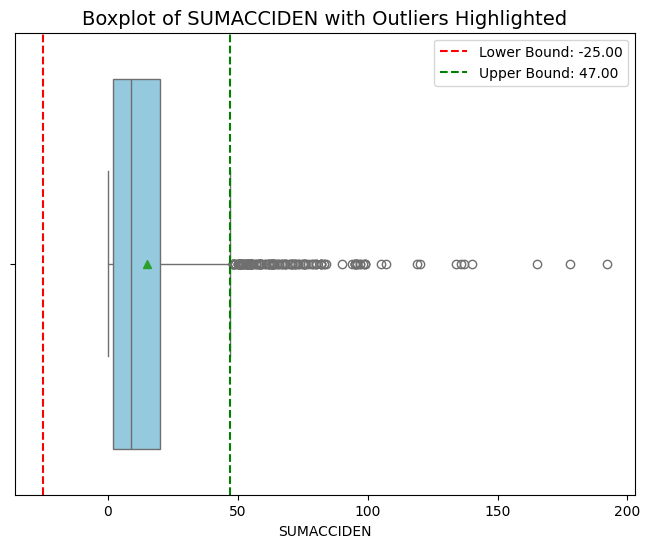

Recommended range for removing outliers in 'SUMACCIDEN':
Lower Bound: -25.00, Upper Bound: 47.00


POP_2018                                              city  \
0         9948                                       ראשון לציון   
7         1737                                     תל אביב - יפו   
14        1997                                     תל אביב - יפו   
28           0                                       יקנעם עילית   
36        8946           פרדס חנה אזורים סטטיסטיים 78 ונווה אבות   
...        ...                                               ...   
2189      2608                                     תל אביב - יפו   
2193     10478                                             בת ים   
2208     28721                                              אילת   
2209     23213                                              אילת   
2218        58  נווה זוהר ים המלח - בתי מלון מפעלי ים המלח(סדום)   

                  MAINUSE    TAZAREA  SUMACCIDEN  DEAD  SEVER_INJ  SLIGH_INJ  \
0                  מגורים     852978          50     0         14         44   
7                  מגורים     230938          64     1         16         62   
14                 מגורים     200117          65     0         11         66   
28                  תעשיה    2213735          49     1         10        103   
36           מגורים+מוסדי    8640781          68     2          9         99   
...                   ...        ...         ...   ...        ...        ...   
2189         מסחר +מגורים     408782          63     1         10         62   
2193               מגורים     289466          56     0          8         59   
2208               מגורים   40728807          96     0          6        123   
2209    מגורים+ בית חולים    4407770          52     0          5         59   
2218  מגורים+תיירות+תעשיה  537716858          54     9         44         76   

      PEDESTRINJ  INJ0_19  ...  INJTOTAL  TOTDRIVERS  MOTORCYCLE  TRUCK  \
0             28       13  ...        58          76          10      0   
7              5        3  ...        79         134          17      0   
14            27       28  ...        77         111          20      0   
28             6       18  ...       114          99           0      0   
36             6       18  ...       110         136           2      3   
...          ...      ...  ...       ...         ...         ...    ...   
2189          27       13  ...        73          99           7      2   
2193          27        7  ...        67          86           9      0   
2208          50       42  ...       129         145           9      3   
2209          21       19  ...        64          80           7      0   
2218           4       20  ...       129          94           2      2   

      BICYCLE  PRIVATE  VEHICLE  ACC_INDEX   Shape_Length    Shape_Area  
0           3       31       62     58.618    3765.786446  8.529776e+05  
7           2       48       98    277.130    1966.358977  2.309382e+05  
14          6       35       89    324.810    1981.948449  2.001168e+05  
28          0       41       80     22.135   14635.271392  2.213735e+06  
36          0       54      104      7.870   14737.713623  8.640781e+06  
...       ...      ...      ...        ...            ...           ...  
2189        4       23       72    154.116    2873.727150  4.087824e+05  
2193        2       23       57    193.460    2945.257900  2.894657e+05  
2208        4       58      132      2.357   30673.776617  4.072881e+07  
2209        0       40       68     11.797    8999.286225  4.407770e+06  
2218        0       31       73      0.100  144865.514687  5.377169e+08  

[164 rows x 22 columns]

In [11]:
find_outliers_with_plot(df, 'SUMACCIDEN')

In [12]:
df[['SUMACCIDEN']].describe()

SUMACCIDEN
count  2637.000000
mean     15.018582
std      19.036584
min       0.000000
25%       2.000000
50%       9.000000
75%      20.000000
max     192.000000

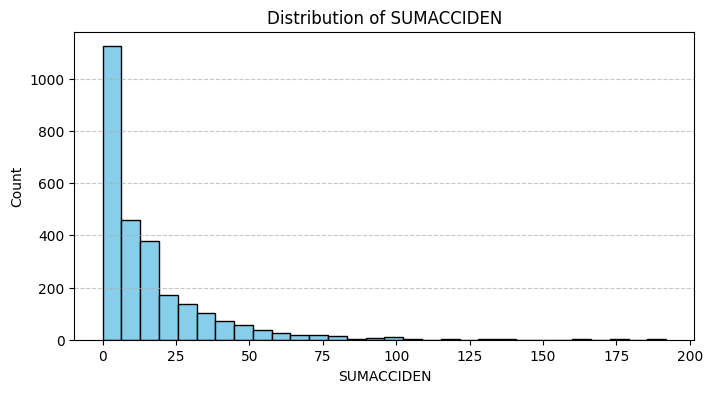

In [13]:
plot_histogram(df, 'SUMACCIDEN')

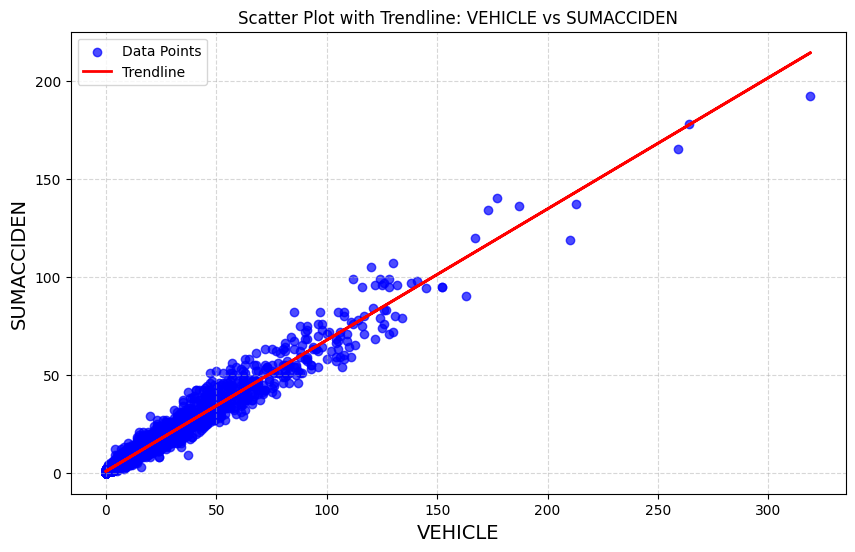

In [14]:
plot_scatter_relationship_with_line(df, x_col='VEHICLE', y_col='SUMACCIDEN')

In [15]:
df = df[df['SUMACCIDEN']<=100]

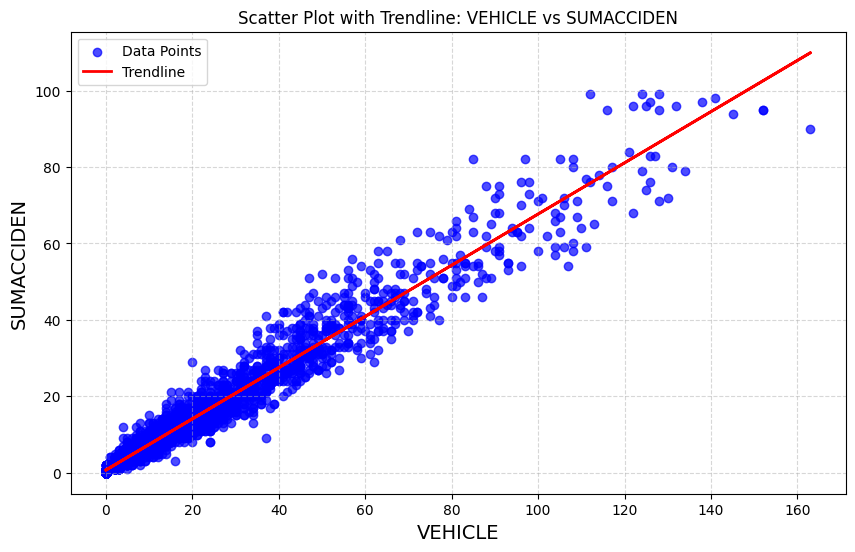

In [16]:
plot_scatter_relationship_with_line(df, x_col='VEHICLE', y_col='SUMACCIDEN')

### Conclusion

The scatter plot analysis of **VEHICLE** versus **SUMACCIDEN** shows a strong linear relationship, indicating that the number of vehicles is a key factor in explaining accident counts.

Outliers with accident counts above 100 deviate significantly from the trend and likely represent unique cases (e.g., poor infrastructure or extreme conditions). To improve model accuracy and prevent overfitting, we chose to **remove outliers above 100 accidents**, ensuring the model captures the typical pattern without being biased by rare extreme values.


### Target Variable Classification

The target variable was classified into **three risk levels**: `Low`, `Medium`, and `High`, based on the **33rd and 66th percentiles** of accident counts (`SUMACCIDEN`). The classification was done as follows:

- **Low (≤ 4)** – Includes values up to the **33rd percentile**.  
- **Medium (5–15)** – Includes values between the **34th and 66th percentiles**.  
- **High (> 15)** – Includes values above the **66th percentile**.

This percentile-based approach ensures balanced categories, with roughly equal numbers of samples in each risk level. This helps the model learn from a well-distributed target variable without being biased toward any specific category.

In [17]:
percentiles = df['SUMACCIDEN'].quantile([0.33, 0.66]).values
df['RISK_LEVEL'] = df['SUMACCIDEN'].apply(lambda x: classify_risk_by_percentiles(x, percentiles))
print("Distribution of RISK_LEVEL:")
display(df['RISK_LEVEL'].value_counts().reset_index(name='Count').rename(columns={'index': 'RISK_LEVEL'}))
# Drop 'SUMACCIDEN' from the data
#df = df.drop(columns=['SUMACCIDEN'])
print("\nUpdated DataFrame:")
display(df.head(5))  

Distribution of RISK_LEVEL:


RISK_LEVEL  Count
0        Low    926
1     Medium    864
2       High    836


Updated DataFrame:


POP_2018         city   MAINUSE  TAZAREA  SUMACCIDEN  DEAD  SEVER_INJ  \
0      9948  ראשון לציון    מגורים   852978          50     0         14   
1      6378        טבריה    מגורים  1475818          10     0          1   
2     12277      ירושלים    מגורים   346241          17     0          4   
3      5341       הרצליה    מגורים   499512          10     1          1   
4         0     קרית אתא  שטח פתוח   508601          46     2         13   

   SLIGH_INJ  PEDESTRINJ  INJ0_19  ...  TOTDRIVERS  MOTORCYCLE  TRUCK  \
0         44          28       13  ...          76          10      0   
1         19           1        4  ...          21           1      0   
2         20          10        8  ...          26           1      0   
3          9           5        1  ...          16           1      0   
4        112           0       19  ...         101           1      2   

   BICYCLE  PRIVATE  VEHICLE  ACC_INDEX  Shape_Length    Shape_Area  \
0        3       31       62     58.618   3765.786446  8.529776e+05   
1        2        8       13      6.776   6981.506526  1.475818e+06   
2        0       12       21     49.099   3958.161078  3.462412e+05   
3        1        9       12     20.020   3065.801740  4.995120e+05   
4        0       54       83     90.444   3692.333819  5.086013e+05   

   RISK_LEVEL  
0        High  
1      Medium  
2        High  
3      Medium  
4        High  

[5 rows x 23 columns]

### 'MAINUSE' Categorization Summary

The original **MAINUSE** column had 101 unique values. These values were grouped into 4 broader categories to reduce complexity and improve interpretability: **Residential** (1850), **Open Area** (212), **Industry** (198), and **Other** (366).


In [18]:
df = process_mainuse_column(df)

==== Original MAINUSE Value Counts ====


MAINUSE  Count
0                      מגורים   1700
1                    שטח פתוח    212
2                       תעשיה    166
3                     לא ידוע    162
4                   בסיס צבאי     31
..                        ...    ...
96                שטח לתחבורה      1
97               מגורים+ מסחר      1
98   בית חולים+ מכללה אקדמאית      1
99      מגורים+ מיועד למגורים      1
100     מתקן ספורט ובית חולים      1

[101 rows x 2 columns]


==== Categorized MAINUSE Value Counts ====


Category  Count
0        מגורים   1850
1           אחר    366
2      שטח פתוח    212
3  תעשייה ומסחר    198


==== Mapped MAINUSE Value Counts ====


MAINUSE  Count
0  Residential   1850
1        Other    366
2    Open Area    212
3     Industry    198

### Verification of `INJTOTAL` Column

The code checks whether the **INJTOTAL** column is correctly calculated as the sum of **DEAD**, **SEVER_INJ**, and **SLIGH_INJ**, based on the suspicion that it represents their total.

In [19]:
df['CHECK_TOTAL'] = df['DEAD'] + df['SEVER_INJ'] + df['SLIGH_INJ']
discrepancies = df[df['CHECK_TOTAL'] != df['INJTOTAL']]

if discrepancies.empty:
    print("INJTOTAL is correctly calculated as the sum of DEAD, SEVER_INJ, and SLIGH_INJ.")
else:
    print(f"Found {len(discrepancies)} discrepancies between INJTOTAL and the sum of DEAD, SEVER_INJ, and SLIGH_INJ.")
df.drop(columns=['INJTOTAL','CHECK_TOTAL'], inplace=True)


INJTOTAL is correctly calculated as the sum of DEAD, SEVER_INJ, and SLIGH_INJ.


 The `INJTOTAL` column is a sum of `DEAD`, `SEVER_INJ`, and `SLIGH_INJ`. Since it is redundant and may cause **multicollinearity** in models, it was removed to ensure better model performance and interpretability.


## Outliers:

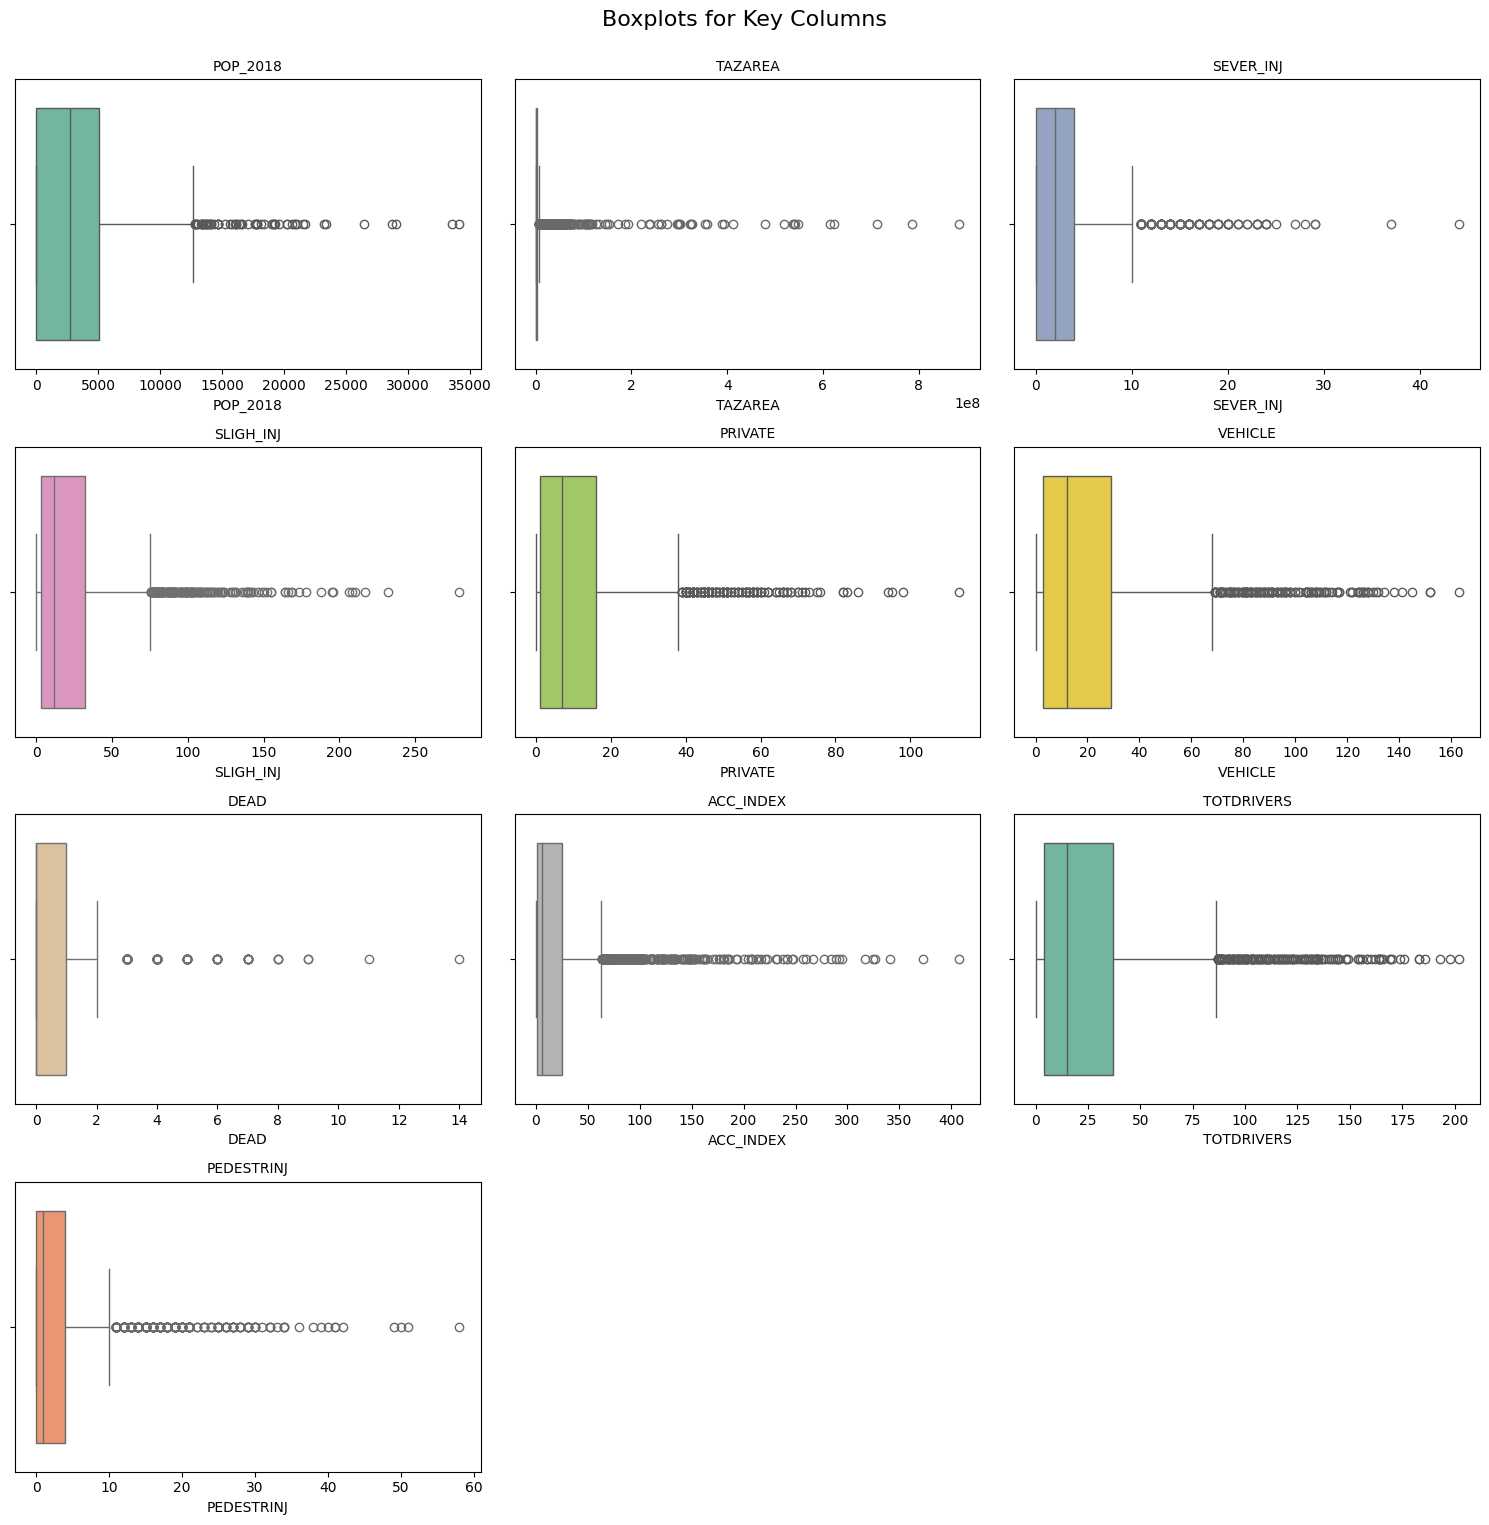

In [20]:
columns_to_plot = ['POP_2018', 'TAZAREA', 'SEVER_INJ', 'SLIGH_INJ', 'PRIVATE', 
                   'VEHICLE', 'DEAD','ACC_INDEX' , 'TOTDRIVERS', 'PEDESTRINJ']
plot_boxplot_matrix(df, columns=columns_to_plot, n_cols=3, figsize=(15, 4), title="Boxplots for Key Columns")

### Now we will check the 'POP_2018' column

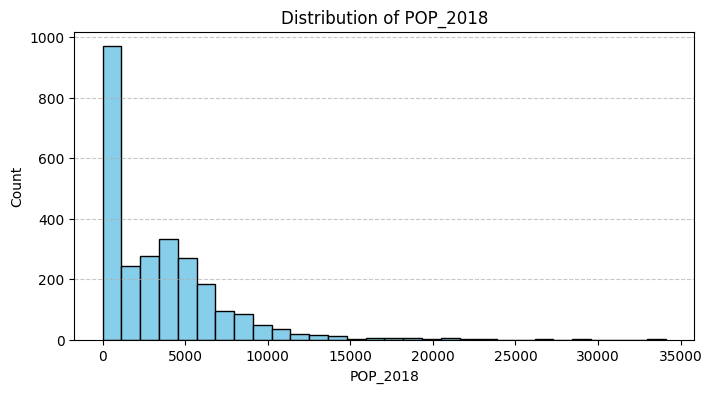

In [21]:
plot_histogram(df, 'POP_2018')

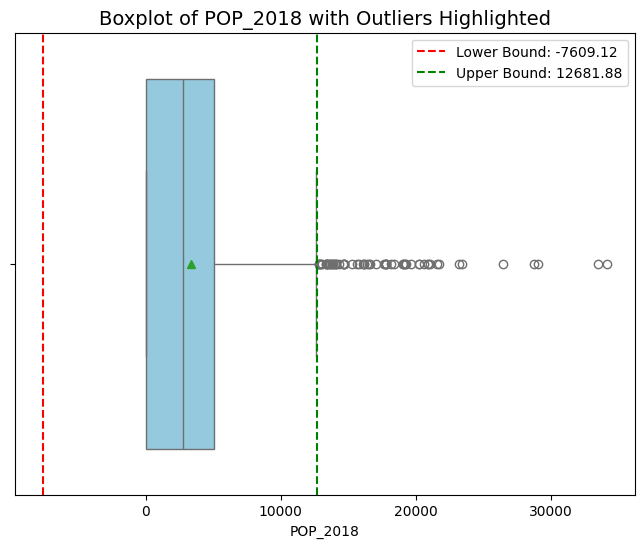

Recommended range for removing outliers in 'POP_2018':
Lower Bound: -7609.12, Upper Bound: 12681.88


POP_2018         city      MAINUSE   TAZAREA  SUMACCIDEN  DEAD  \
8        19257      בני ברק  Residential    435224          26     0   
33       13994      בני ברק  Residential    432759          29     0   
80       13322         חדרה  Residential   7127143          28     0   
93       29022       אופקים  Residential  10542599          46     1   
139      16383  ראשון לציון  Residential    727958          67     2   
...        ...          ...          ...       ...         ...   ...   
2391     21684      ירושלים  Residential    367489           0     0   
2433     20203       תל שבע  Residential   6137110           0     0   
2440     16154      ירושלים  Residential   1013695           0     0   
2472     16154      ירושלים  Residential   1032185           0     0   
2485     12938        טייבה  Residential   2916511           0     0   

      SEVER_INJ  SLIGH_INJ  PEDESTRINJ  INJ0_19  ...  TOTDRIVERS  MOTORCYCLE  \
8             6         23          21       15  ...          35           4   
33            6         23          18       15  ...          38           4   
80            6         38           8       11  ...          51           3   
93           13         73          14       16  ...          81           0   
139          14         66          39        8  ...         108           8   
...         ...        ...         ...      ...  ...         ...         ...   
2391          0          0           0        0  ...           0           0   
2433          0          0           0        0  ...           0           0   
2440          0          0           0        0  ...           0           0   
2472          0          0           0        0  ...           0           0   
2485          0          0           0        0  ...           0           0   

      TRUCK  BICYCLE  PRIVATE  VEHICLE  ACC_INDEX  Shape_Length    Shape_Area  \
8         0        3       14       29     59.739   2970.819370  4.352237e+05   
33        0        0       10       20     67.012   3605.799081  4.327586e+05   
80        0        1       25       37      3.929  13253.427799  7.127143e+06   
93        1        2       38       67      4.363  13919.853303  1.054260e+07   
139       0        2       51       85     92.038   4831.802538  7.279578e+05   
...     ...      ...      ...      ...        ...           ...           ...   
2391      0        0        0        0      0.000   2527.242107  3.674893e+05   
2433      0        0        0        0      0.000  11866.954609  6.137110e+06   
2440      0        0        0        0      0.000   5321.850271  1.013695e+06   
2472      0        0        0        0      0.000   5795.464195  1.032185e+06   
2485      0        0        0        0      0.000   7744.510349  2.916511e+06   

      RISK_LEVEL  
8           High  
33          High  
80          High  
93          High  
139         High  
...          ...  
2391         Low  
2433         Low  
2440         Low  
2472         Low  
2485         Low  

[64 rows x 22 columns]

In [22]:
find_outliers_with_plot(df, 'POP_2018')


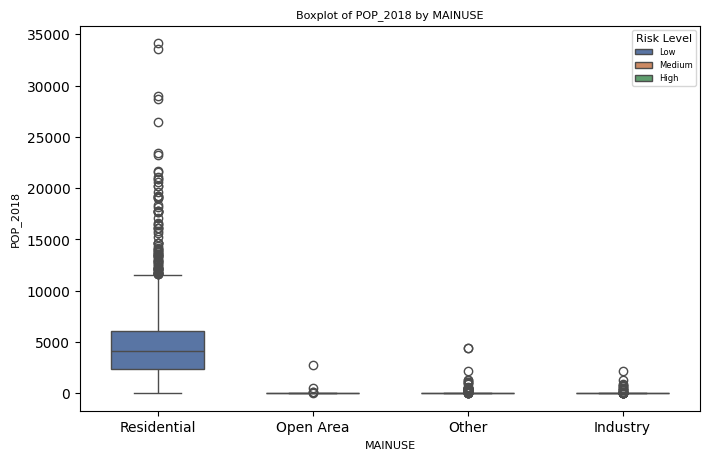

In [23]:
plot_boxplot(df, 'MAINUSE', 'POP_2018', figsize=(8, 5), title=None)

#### We analyzed the **`POP_2018`** column and identified several outliers with unusually high population values. Further investigation, based on the **`MAINUSE`** column (area usage), showed that these outliers were primarily associated with highly populated residential areas. Since these values reflect real-world characteristics and are significant for understanding accident risk in different area types, we chose to retain them in the dataset.

### Now we will check the 'TAZAREA' column:

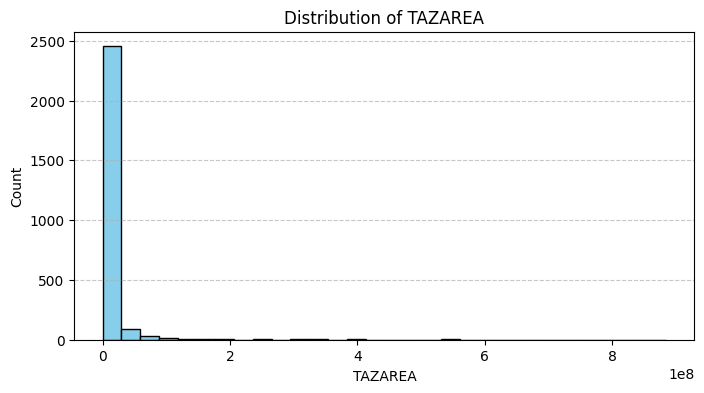

In [24]:
plot_histogram(df, 'TAZAREA')

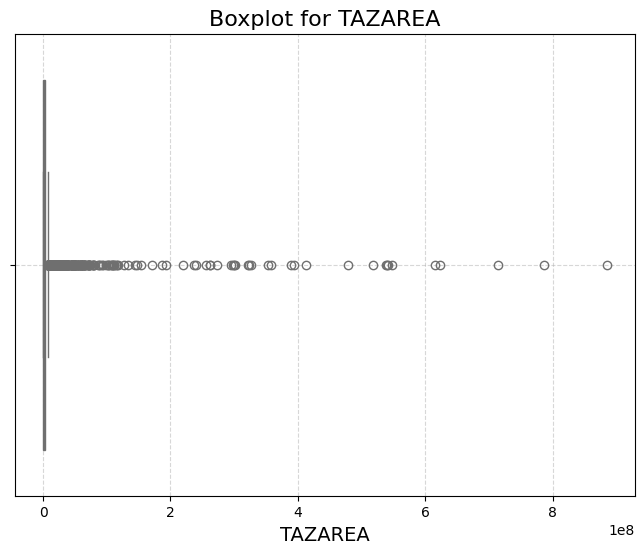

In [25]:
plot_single_boxplot(df, column='TAZAREA')

In [26]:

# Convert the summary statistics of 'TAZAREA' column to a DataFrame and display it
summary_stats = df['TAZAREA'].describe().to_frame().T
display(summary_stats)


count          mean           std  min       25%       50%  \
TAZAREA  2626.0  1.053200e+07  5.034331e+07  3.0  401627.5  784605.5   

                75%          max  
TAZAREA  3219331.25  884527231.0

Based on the data distribution, the maximum value in the `TAZAREA` column, 884,527,200, is highly unusual compared to the rest of the table. This is likely a data entry error, so we recommend removing outliers above 10,000,000.

In [27]:
df = df[df['TAZAREA'] <= 10000000]

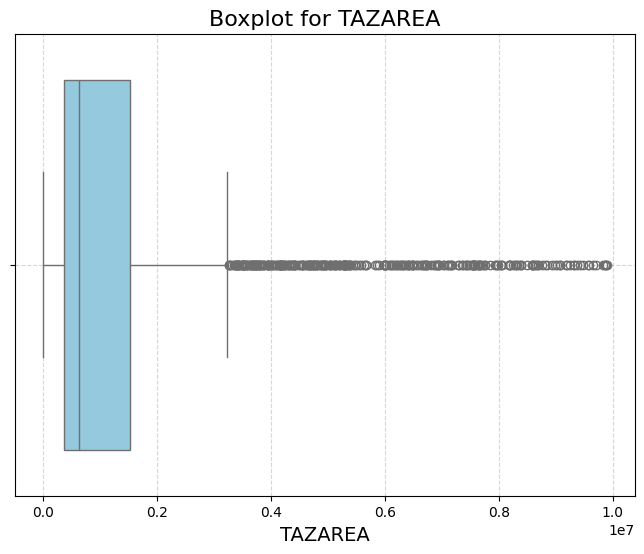

In [28]:
plot_single_boxplot(df, column='TAZAREA')

### Checking the 'DEAD' column:

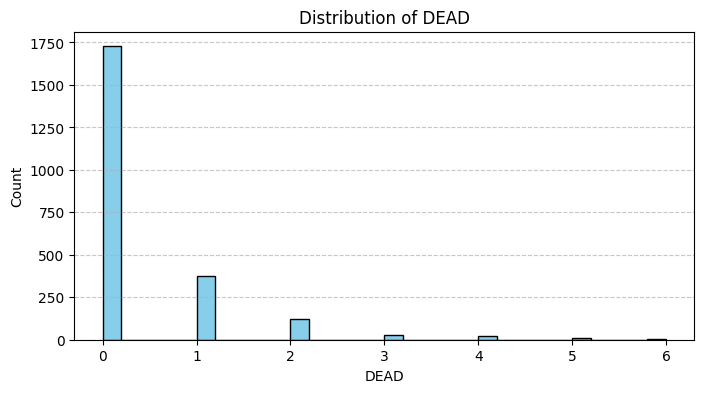

In [29]:
plot_histogram(df, 'DEAD')

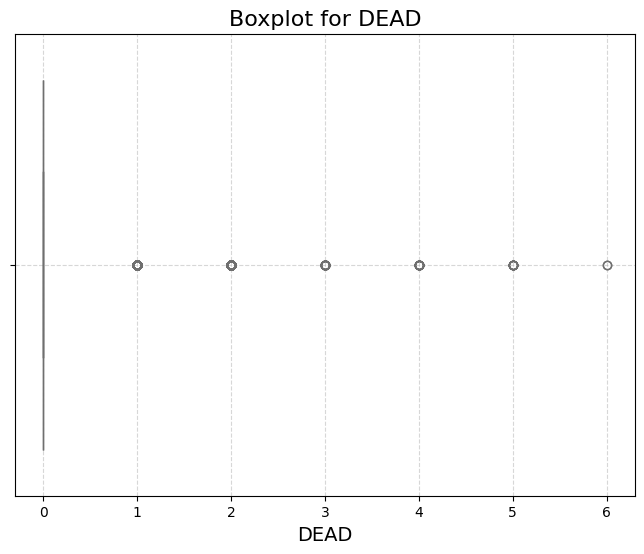

In [30]:
plot_single_boxplot(df, column='DEAD')

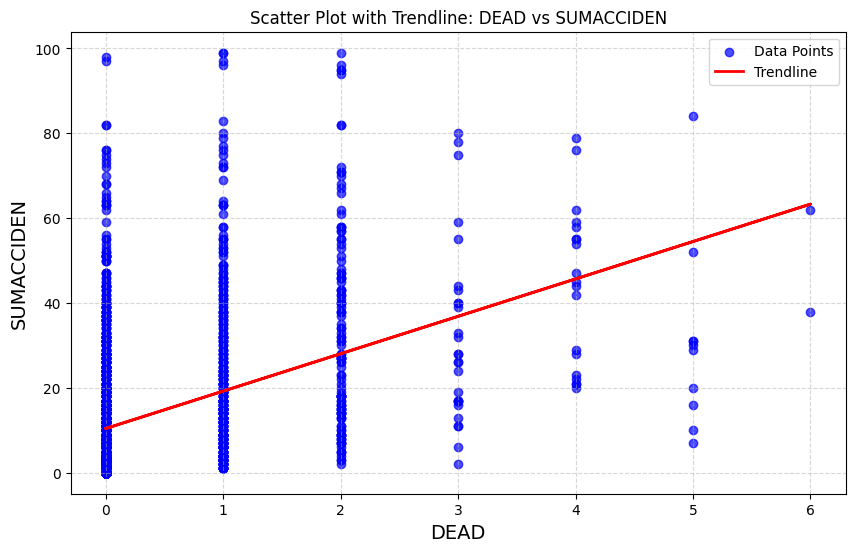

In [31]:
plot_scatter_relationship_with_line(df, x_col='DEAD', y_col='SUMACCIDEN')

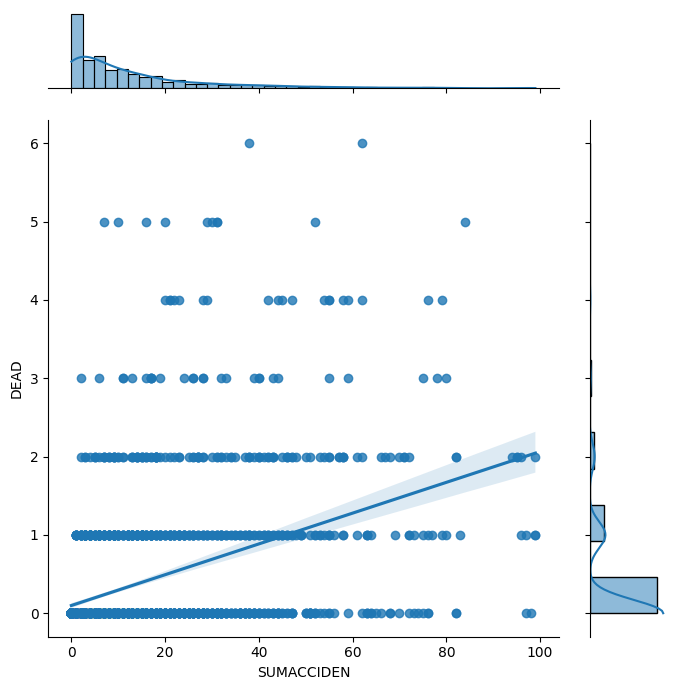

In [32]:
sns.jointplot(data=df, x='SUMACCIDEN', y='DEAD', kind='reg', height=7, space=0.4)
plt.show()


#### The joint plot shows a positive correlation between `SUMACCIDEN` and `DEAD`, but it also highlights several potential outliers. These outliers could disproportionately affect the trend and may require further investigation or removal.

#### Outliers in the `DEAD` column were already indirectly addressed when handling outliers in related columns. Therefore, further removal is unnecessary to avoid overly restricting the range of values and to preserve critical variability for a more comprehensive analysis.

### Checking the 'SEVER_INJ' column:

In [33]:
summary_stats = df['SEVER_INJ'].describe().to_frame().T
display(summary_stats)

count      mean      std  min  25%  50%  75%   max
SEVER_INJ  2280.0  2.659649  3.53059  0.0  0.0  1.0  4.0  29.0

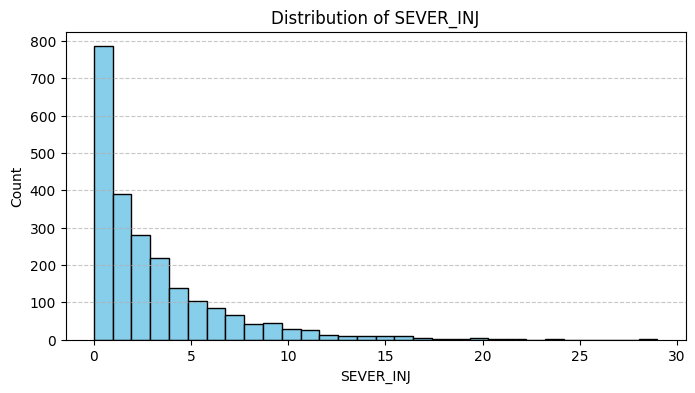

In [34]:
plot_histogram(df, 'SEVER_INJ')

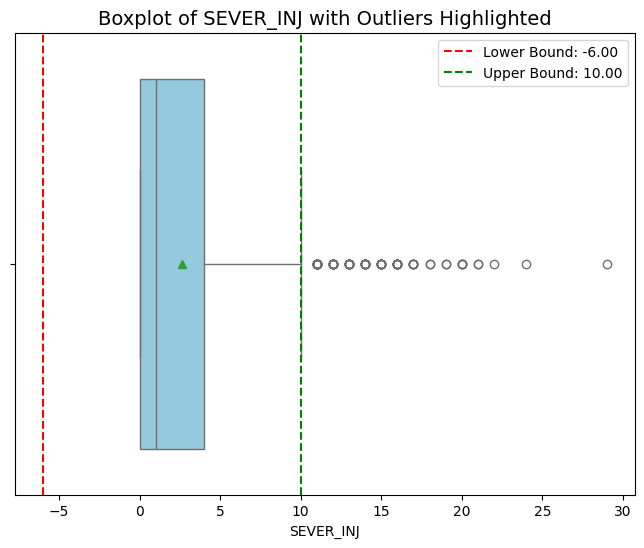

Recommended range for removing outliers in 'SEVER_INJ':
Lower Bound: -6.00, Upper Bound: 10.00


POP_2018           city      MAINUSE  TAZAREA  SUMACCIDEN  DEAD  \
0         9948    ראשון לציון  Residential   852978          50     0   
4            0       קרית אתא    Open Area   508601          46     2   
7         1737  תל אביב - יפו  Residential   230938          64     1   
14        1997  תל אביב - יפו  Residential   200117          65     0   
39         970  תל אביב - יפו  Residential   188991          77     1   
...        ...            ...          ...      ...         ...   ...   
2113      8364         רמת גן  Residential   297725          63     0   
2134      3276         רמת גן  Residential  2088908          58     4   
2139      3608         רמת גן  Residential   207973          45     1   
2146     11753  תל אביב - יפו  Residential   500691          73     1   
2198         0       ראש העין        Other  1368014          47     0   

      SEVER_INJ  SLIGH_INJ  PEDESTRINJ  INJ0_19  ...  TOTDRIVERS  MOTORCYCLE  \
0            14         44          28       13  ...          76          10   
4            13        112           0       19  ...         101           1   
7            16         62           5        3  ...         134          17   
14           11         66          27       28  ...         111          20   
39           13         81          21        7  ...         148          33   
...         ...        ...         ...      ...  ...         ...         ...   
2113         11         67          25        2  ...         104           9   
2134         13         88           4       15  ...         137          11   
2139         12         41          17        4  ...          74          12   
2146         13         80          22       10  ...         131          18   
2198         14         73           1        8  ...          91           5   

      TRUCK  BICYCLE  PRIVATE  VEHICLE  ACC_INDEX  Shape_Length    Shape_Area  \
0         0        3       31       62     58.618   3765.786446  8.529776e+05   
4         2        0       54       83     90.444   3692.333819  5.086013e+05   
7         0        2       48       98    277.130   1966.358977  2.309382e+05   
14        0        6       35       89    324.810   1981.948449  2.001168e+05   
39        2       14       33      111    407.426   1819.914576  1.889915e+05   
...     ...      ...      ...      ...        ...           ...           ...   
2113      0        3       35       75    211.604   2367.285168  2.977254e+05   
2134      3        1       56      108     27.766   7205.233011  2.088908e+06   
2139      0        2       28       57    216.374   1937.705770  2.079729e+05   
2146      2        7       26       91    145.798   2831.827938  5.006914e+05   
2198      1        0       42       74     34.356   5571.934988  1.368014e+06   

      RISK_LEVEL  
0           High  
4           High  
7           High  
14          High  
39          High  
...          ...  
2113        High  
2134        High  
2139        High  
2146        High  
2198        High  

[97 rows x 22 columns]

In [35]:
find_outliers_with_plot(df, 'SEVER_INJ')

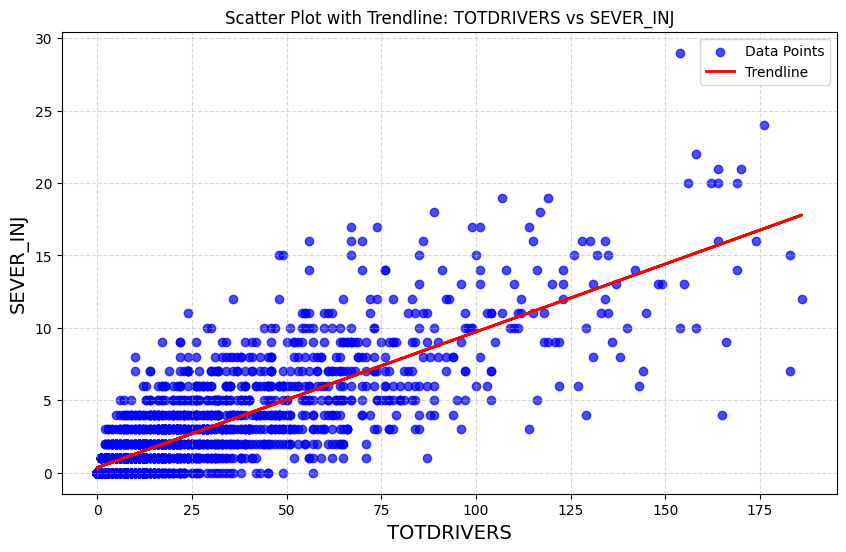

In [36]:
plot_scatter_relationship_with_line(df, x_col='TOTDRIVERS', y_col='SEVER_INJ')


#### The high values in the SEVER_INJ column largely represent a true trend, as they align with the positive relationship between the number of drivers and severe injuries. However, a few extreme points may still be considered outliers and warrant further investigation. Therefore, it is better to retain these high values for further analysis while carefully examining potential outliers.


### Checking the 'SLIGH_INJ' column:

In [37]:
summary_stats = df['SLIGH_INJ'].describe().to_frame().T
display(summary_stats)

count       mean        std  min  25%   50%   75%    max
SLIGH_INJ  2280.0  19.607018  25.529564  0.0  2.0  11.0  26.0  232.0

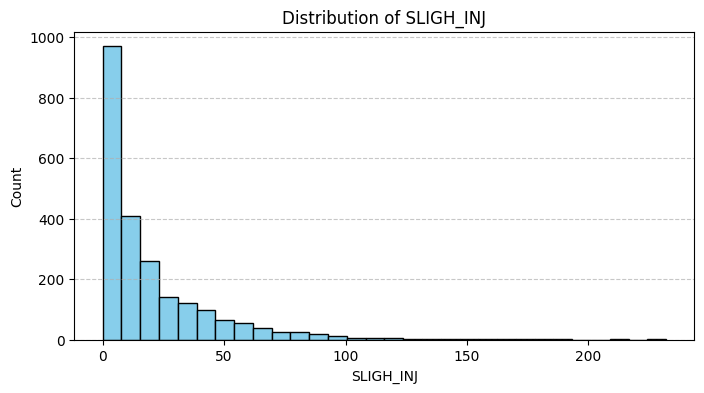

In [38]:
plot_histogram(df, 'SLIGH_INJ')

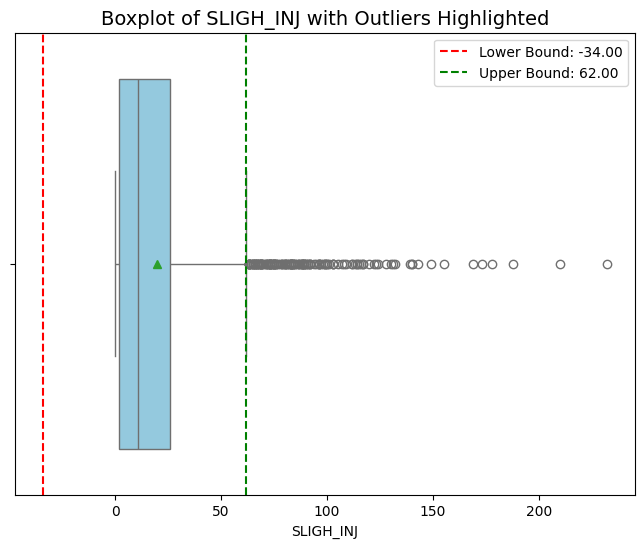

Recommended range for removing outliers in 'SLIGH_INJ':
Lower Bound: -34.00, Upper Bound: 62.00


POP_2018                                     city      MAINUSE  TAZAREA  \
4            0                                 קרית אתא    Open Area   508601   
14        1997                            תל אביב - יפו  Residential   200117   
28           0                              יקנעם עילית     Industry  2213735   
36        8946  פרדס חנה אזורים סטטיסטיים 78 ונווה אבות  Residential  8640781   
39         970                            תל אביב - יפו  Residential   188991   
...        ...                                      ...          ...      ...   
2134      3276                                   רמת גן  Residential  2088908   
2146     11753                            תל אביב - יפו  Residential   500691   
2152      1638                          ברוש תדהר תאשור  Residential  9022919   
2198         0                                 ראש העין        Other  1368014   
2231         0                                      נשר     Industry   895692   

      SUMACCIDEN  DEAD  SEVER_INJ  SLIGH_INJ  PEDESTRINJ  INJ0_19  ...  \
4             46     2         13        112           0       19  ...   
14            65     0         11         66          27       28  ...   
28            49     1         10        103           6       18  ...   
36            68     2          9         99           6       18  ...   
39            77     1         13         81          21        7  ...   
...          ...   ...        ...        ...         ...      ...  ...   
2134          58     4         13         88           4       15  ...   
2146          73     1         13         80          22       10  ...   
2152          22     1          9         64           0       17  ...   
2198          47     0         14         73           1        8  ...   
2231          39     0          6         82           2       20  ...   

      TOTDRIVERS  MOTORCYCLE  TRUCK  BICYCLE  PRIVATE  VEHICLE  ACC_INDEX  \
4            101           1      2        0       54       83     90.444   
14           111          20      0        6       35       89    324.810   
28            99           0      0        0       41       80     22.135   
36           136           2      3        0       54      104      7.870   
39           148          33      2       14       33      111    407.426   
...          ...         ...    ...      ...      ...      ...        ...   
2134         137          11      3        1       56      108     27.766   
2146         131          18      2        7       26       91    145.798   
2152          42           1      1        0       18       32      2.438   
2198          91           5      1        0       42       74     34.356   
2231          76           0      0        0       29       52     43.542   

      Shape_Length    Shape_Area  RISK_LEVEL  
4      3692.333819  5.086013e+05        High  
14     1981.948449  2.001168e+05        High  
28    14635.271392  2.213735e+06        High  
36    14737.713623  8.640781e+06        High  
39     1819.914576  1.889915e+05        High  
...            ...           ...         ...  
2134   7205.233011  2.088908e+06        High  
2146   2831.827938  5.006914e+05        High  
2152  12099.497311  9.022919e+06        High  
2198   5571.934988  1.368014e+06        High  
2231   5321.921761  8.956922e+05        High  

[149 rows x 22 columns]

In [39]:
find_outliers_with_plot(df, 'SLIGH_INJ')

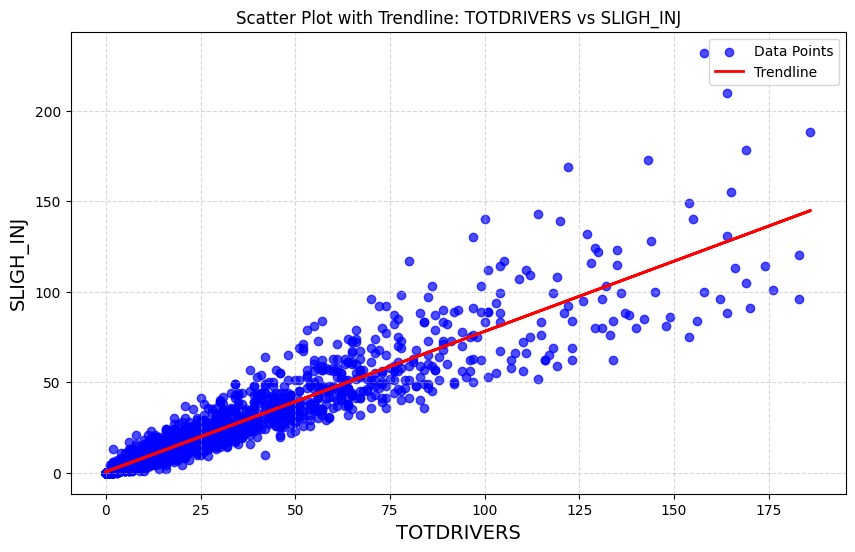

In [40]:
plot_scatter_relationship_with_line(df, x_col='TOTDRIVERS', y_col='SLIGH_INJ')


#### 
The scatter plot shows a clear positive relationship between the total number of drivers (**TOTDRIVERS**) and the number of slight injuries (**SLIGH_INJ**). As the number of drivers increases, the number of slight injuries increases proportionally, which is reflected by the strong alignment of most data points along the trendline.

Outliers with high values of slight injuries are consistent with the general trend and likely represent real cases involving a high number of drivers. Therefore, it is reasonable **not to remove these outliers**, as they provide valuable information and accurately reflect the underlying relationship between the variables.


### Checking the 'PEDESTRINJ' column:

In [41]:
summary_stats = df['PEDESTRINJ'].describe().to_frame().T
display(summary_stats)

count      mean       std  min  25%  50%  75%   max
PEDESTRINJ  2280.0  3.835965  6.232185  0.0  0.0  1.0  5.0  58.0

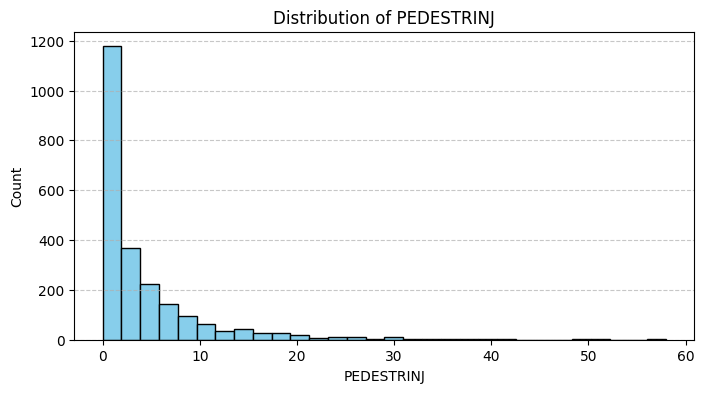

In [42]:
plot_histogram(df, 'PEDESTRINJ')

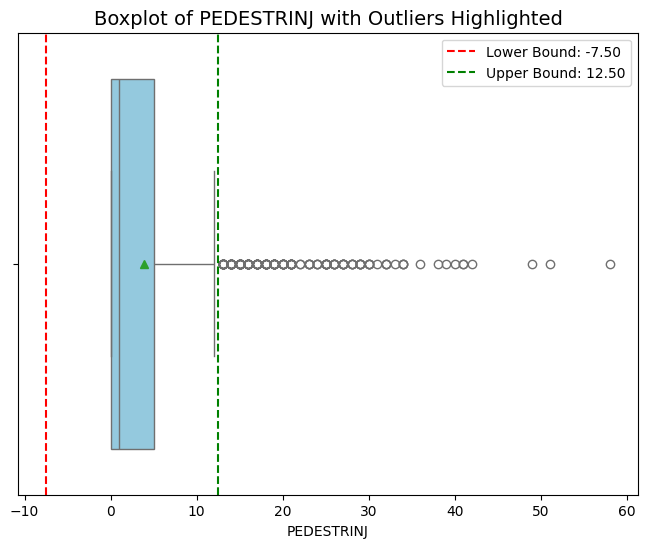

Recommended range for removing outliers in 'PEDESTRINJ':
Lower Bound: -7.50, Upper Bound: 12.50


POP_2018           city      MAINUSE  TAZAREA  SUMACCIDEN  DEAD  \
0         9948    ראשון לציון  Residential   852978          50     0   
8        19257        בני ברק  Residential   435224          26     0   
14        1997  תל אביב - יפו  Residential   200117          65     0   
33       13994        בני ברק  Residential   432759          29     0   
39         970  תל אביב - יפו  Residential   188991          77     1   
...        ...            ...          ...      ...         ...   ...   
2182      2557        כפר סבא  Residential   297148          21     0   
2189      2608  תל אביב - יפו  Residential   408782          63     1   
2193     10478          בת ים  Residential   289466          56     0   
2209     23213           אילת  Residential  4407770          52     0   
2227      8121        ירושלים  Residential   402376          42     4   

      SEVER_INJ  SLIGH_INJ  PEDESTRINJ  INJ0_19  ...  TOTDRIVERS  MOTORCYCLE  \
0            14         44          28       13  ...          76          10   
8             6         23          21       15  ...          35           4   
14           11         66          27       28  ...         111          20   
33            6         23          18       15  ...          38           4   
39           13         81          21        7  ...         148          33   
...         ...        ...         ...      ...  ...         ...         ...   
2182          3         23          17        4  ...          31           0   
2189         10         62          27       13  ...          99           7   
2193          8         59          27        7  ...          86           9   
2209          5         59          21       19  ...          80           7   
2227          9         35          25       12  ...          57           2   

      TRUCK  BICYCLE  PRIVATE  VEHICLE  ACC_INDEX  Shape_Length    Shape_Area  \
0         0        3       31       62     58.618   3765.786446  8.529776e+05   
8         0        3       14       29     59.739   2970.819370  4.352237e+05   
14        0        6       35       89    324.810   1981.948449  2.001168e+05   
33        0        0       10       20     67.012   3605.799081  4.327586e+05   
39        2       14       33      111    407.426   1819.914576  1.889915e+05   
...     ...      ...      ...      ...        ...           ...           ...   
2182      0        1       11       19     70.672   2680.061222  2.971483e+05   
2189      2        4       23       72    154.116   2873.727150  4.087824e+05   
2193      0        2       23       57    193.460   2945.257900  2.894657e+05   
2209      0        0       40       68     11.797   8999.286225  4.407770e+06   
2227      1        2       24       41    104.380   3457.362088  4.023757e+05   

      RISK_LEVEL  
0           High  
8           High  
14          High  
33          High  
39          High  
...          ...  
2182        High  
2189        High  
2193        High  
2209        High  
2227        High  

[191 rows x 22 columns]

In [43]:
find_outliers_with_plot(df, 'PEDESTRINJ')

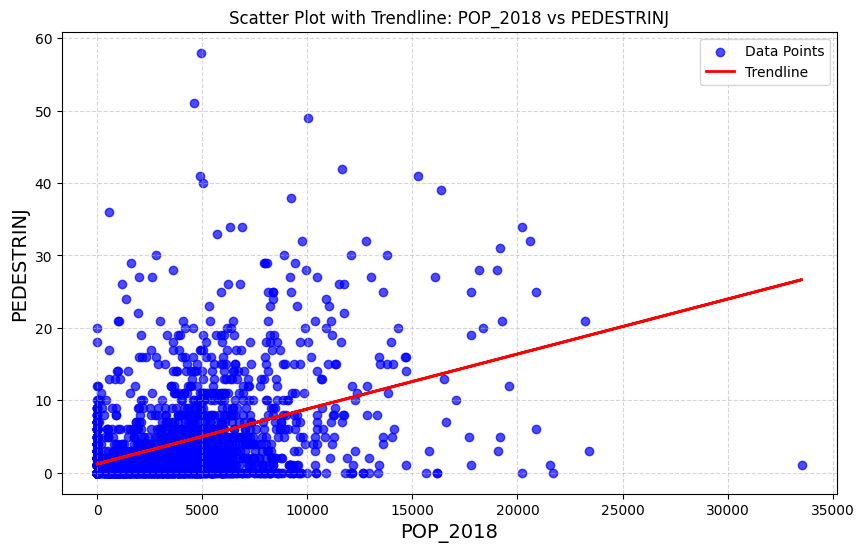

In [44]:
plot_scatter_relationship_with_line(df, x_col='POP_2018', y_col='PEDESTRINJ')

In [45]:
df = df[df['PEDESTRINJ'] <= 40]

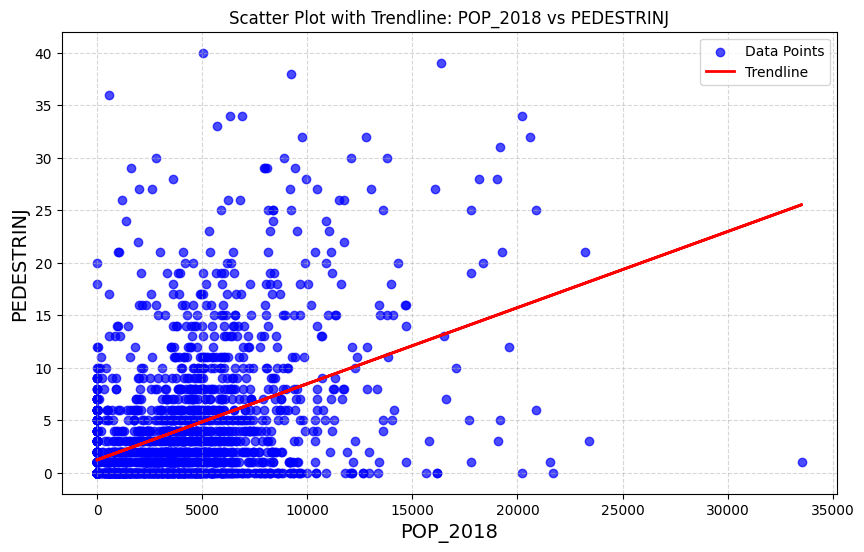

In [46]:
plot_scatter_relationship_with_line(df, x_col='POP_2018', y_col='PEDESTRINJ')

The removal of outliers in the 'PEDESTRINJ' column seems justified as the second graph demonstrates a clearer trend, and the data distribution appears less scattered. This helps in better understanding the relationship between variables without the influence of extreme outliers.

### Checking the 'PRIVATE' column:

In [47]:
summary_stats = df['PRIVATE'].describe().to_frame().T
display(summary_stats)

count       mean        std  min  25%  50%   75%   max
PRIVATE  2274.0  10.358399  12.948864  0.0  1.0  6.0  15.0  98.0

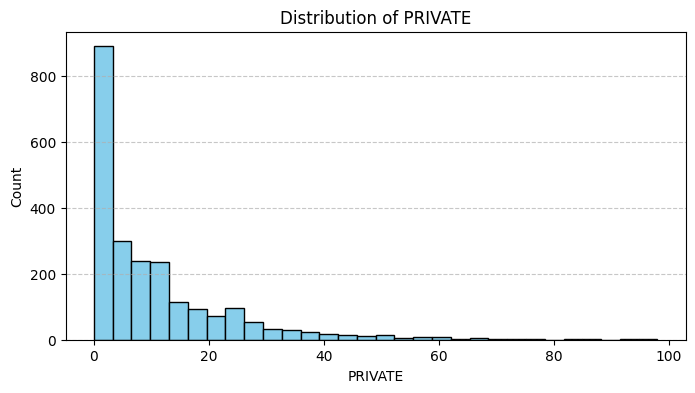

In [48]:
plot_histogram(df, 'PRIVATE')

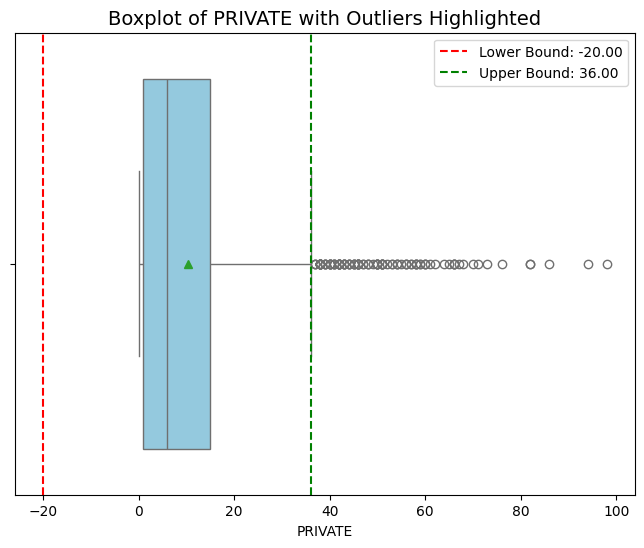

Recommended range for removing outliers in 'PRIVATE':
Lower Bound: -20.00, Upper Bound: 36.00


POP_2018                                     city      MAINUSE  TAZAREA  \
4            0                                 קרית אתא    Open Area   508601   
7         1737                            תל אביב - יפו  Residential   230938   
27           0                               כפר שמריהו        Other  1168040   
28           0                              יקנעם עילית     Industry  2213735   
36        8946  פרדס חנה אזורים סטטיסטיים 78 ונווה אבות  Residential  8640781   
...        ...                                      ...          ...      ...   
2093         0                                פתח תקווה     Industry  1161177   
2098      7286                                     חדרה  Residential  4623946   
2134      3276                                   רמת גן  Residential  2088908   
2198         0                                 ראש העין        Other  1368014   
2209     23213                                     אילת  Residential  4407770   

      SUMACCIDEN  DEAD  SEVER_INJ  SLIGH_INJ  PEDESTRINJ  INJ0_19  ...  \
4             46     2         13        112           0       19  ...   
7             64     1         16         62           5        3  ...   
27            38     0          8         60           0        6  ...   
28            49     1         10        103           6       18  ...   
36            68     2          9         99           6       18  ...   
...          ...   ...        ...        ...         ...      ...  ...   
2093          75     3         10        149           3       31  ...   
2098          94     2         12        188           5       26  ...   
2134          58     4         13         88           4       15  ...   
2198          47     0         14         73           1        8  ...   
2209          52     0          5         59          21       19  ...   

      TOTDRIVERS  MOTORCYCLE  TRUCK  BICYCLE  PRIVATE  VEHICLE  ACC_INDEX  \
4            101           1      2        0       54       83     90.444   
7            134          17      0        2       48       98    277.130   
27            90           5      0        0       38       59     32.533   
28            99           0      0        0       41       80     22.135   
36           136           2      3        0       54      104      7.870   
...          ...         ...    ...      ...      ...      ...        ...   
2093         154           6      3        1       68      116     64.590   
2098         186           2      4        3       94      145     20.329   
2134         137          11      3        1       56      108     27.766   
2198          91           5      1        0       42       74     34.356   
2209          80           7      0        0       40       68     11.797   

      Shape_Length    Shape_Area  RISK_LEVEL  
4      3692.333819  5.086013e+05        High  
7      1966.358977  2.309382e+05        High  
27     5227.192944  1.168040e+06        High  
28    14635.271392  2.213735e+06        High  
36    14737.713623  8.640781e+06        High  
...            ...           ...         ...  
2093   4929.175131  1.161177e+06        High  
2098  13044.478003  4.623946e+06        High  
2134   7205.233011  2.088908e+06        High  
2198   5571.934988  1.368014e+06        High  
2209   8999.286225  4.407770e+06        High  

[114 rows x 22 columns]

In [49]:
find_outliers_with_plot(df, 'PRIVATE')

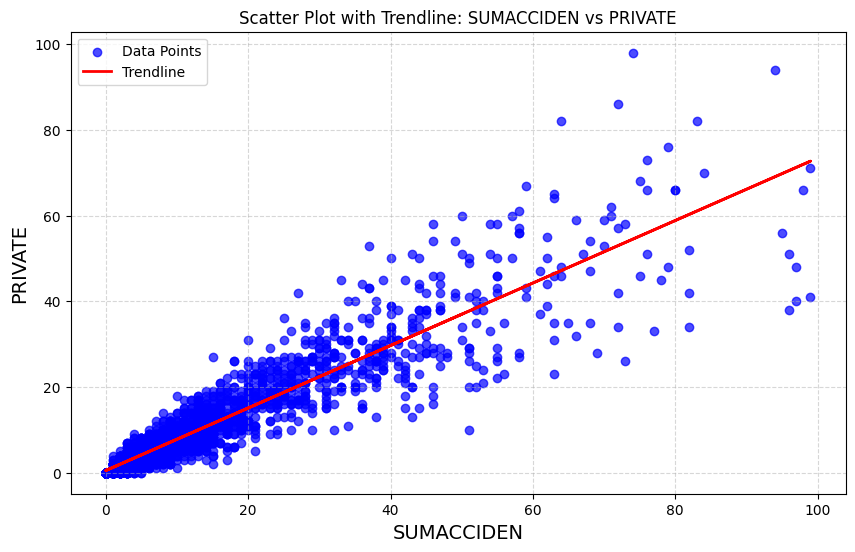

In [50]:
plot_scatter_relationship_with_line(df, x_col='SUMACCIDEN', y_col='PRIVATE')


The scatter plot shows a strong positive correlation between the total number of accidents (**SUMACCIDEN**) and the number of private vehicles involved (**PRIVATE**). As the total number of accidents increases, the number of private vehicles involved also increases proportionally, with most data points aligning well along the trendline.

While there are some high-value outliers, they generally follow the overall trend and likely represent real cases with a large number of private vehicles involved in accidents. Therefore, it is reasonable **not to remove these outliers**, as they contribute valuable information about high-accident scenarios and help preserve the accuracy of the analysis.


### Checking the 'VEHICLE' column:

In [51]:
summary_stats = df['VEHICLE'].describe().to_frame().T
display(summary_stats)

count       mean        std  min  25%   50%   75%    max
VEHICLE  2274.0  18.863237  23.516153  0.0  2.0  11.0  26.0  145.0

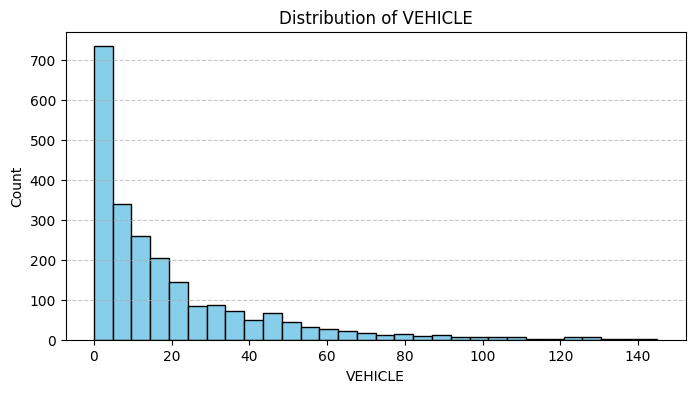

In [52]:
plot_histogram(df, 'VEHICLE')

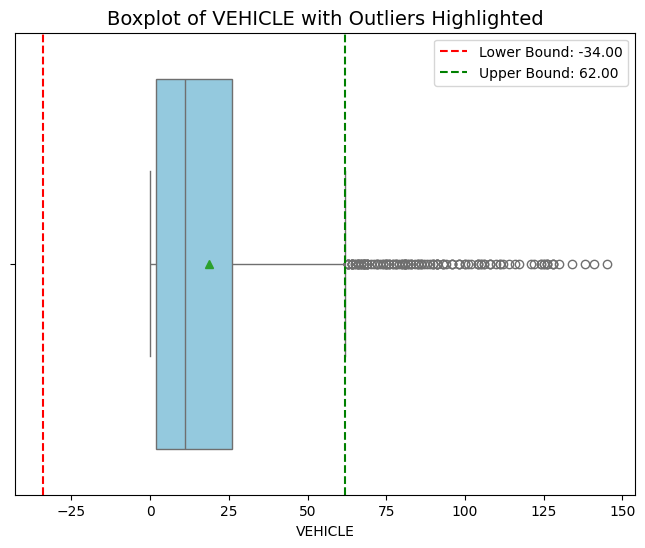

Recommended range for removing outliers in 'VEHICLE':
Lower Bound: -34.00, Upper Bound: 62.00


POP_2018                                     city      MAINUSE  TAZAREA  \
4            0                                 קרית אתא    Open Area   508601   
7         1737                            תל אביב - יפו  Residential   230938   
14        1997                            תל אביב - יפו  Residential   200117   
28           0                              יקנעם עילית     Industry  2213735   
36        8946  פרדס חנה אזורים סטטיסטיים 78 ונווה אבות  Residential  8640781   
...        ...                                      ...          ...      ...   
2134      3276                                   רמת גן  Residential  2088908   
2146     11753                            תל אביב - יפו  Residential   500691   
2189      2608                            תל אביב - יפו  Residential   408782   
2198         0                                 ראש העין        Other  1368014   
2209     23213                                     אילת  Residential  4407770   

      SUMACCIDEN  DEAD  SEVER_INJ  SLIGH_INJ  PEDESTRINJ  INJ0_19  ...  \
4             46     2         13        112           0       19  ...   
7             64     1         16         62           5        3  ...   
14            65     0         11         66          27       28  ...   
28            49     1         10        103           6       18  ...   
36            68     2          9         99           6       18  ...   
...          ...   ...        ...        ...         ...      ...  ...   
2134          58     4         13         88           4       15  ...   
2146          73     1         13         80          22       10  ...   
2189          63     1         10         62          27       13  ...   
2198          47     0         14         73           1        8  ...   
2209          52     0          5         59          21       19  ...   

      TOTDRIVERS  MOTORCYCLE  TRUCK  BICYCLE  PRIVATE  VEHICLE  ACC_INDEX  \
4            101           1      2        0       54       83     90.444   
7            134          17      0        2       48       98    277.130   
14           111          20      0        6       35       89    324.810   
28            99           0      0        0       41       80     22.135   
36           136           2      3        0       54      104      7.870   
...          ...         ...    ...      ...      ...      ...        ...   
2134         137          11      3        1       56      108     27.766   
2146         131          18      2        7       26       91    145.798   
2189          99           7      2        4       23       72    154.116   
2198          91           5      1        0       42       74     34.356   
2209          80           7      0        0       40       68     11.797   

      Shape_Length    Shape_Area  RISK_LEVEL  
4      3692.333819  5.086013e+05        High  
7      1966.358977  2.309382e+05        High  
14     1981.948449  2.001168e+05        High  
28    14635.271392  2.213735e+06        High  
36    14737.713623  8.640781e+06        High  
...            ...           ...         ...  
2134   7205.233011  2.088908e+06        High  
2146   2831.827938  5.006914e+05        High  
2189   2873.727150  4.087824e+05        High  
2198   5571.934988  1.368014e+06        High  
2209   8999.286225  4.407770e+06        High  

[134 rows x 22 columns]

In [53]:
find_outliers_with_plot(df, 'VEHICLE')

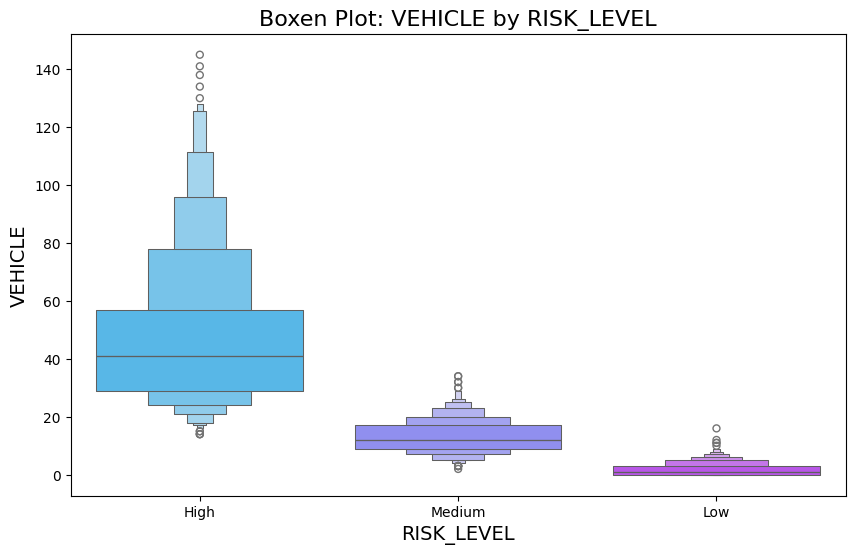

In [54]:
plot_boxen(df, 'RISK_LEVEL', 'VEHICLE', palette='cool', figsize=(10, 6))

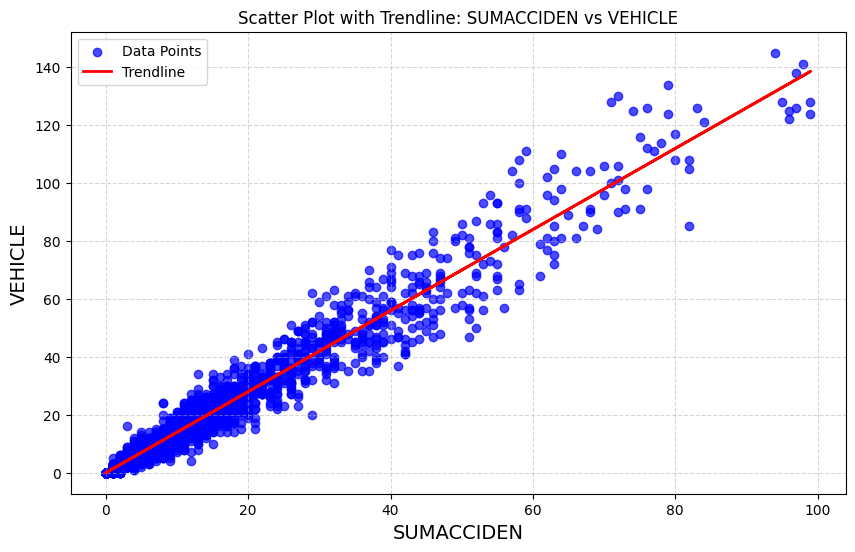

In [55]:
plot_scatter_relationship_with_line(df, x_col='SUMACCIDEN', y_col='VEHICLE')


Outliers in the **VEHICLE** column were analyzed against both the numeric target (**SUMACCIDEN**) and the classified target** (risk leve**ls). The analysis with the numeric target confirmed that these outliers, while extreme, follow the overall trend and represent realistic cases of high vehicle counts leading to high accident counts. When analyzed with the classified target, the outliers were found to contribute valuable information for distinguishing between risk levels. Therefore, retaining these outliers ensures that the classification model captures real-world patterns, including both typical and extreme cases.


### Checking the 'ACC_INDEX' column:

In [56]:
summary_stats = df['ACC_INDEX'].describe().to_frame().T
display(summary_stats)

count       mean        std  min   25%    50%       75%      max
ACC_INDEX  2274.0  25.679928  42.671599  0.0  1.59  8.582  30.25125  407.426

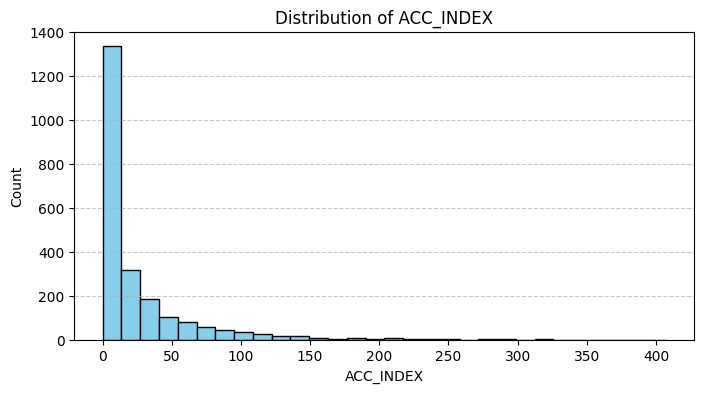

In [57]:
plot_histogram(df, 'ACC_INDEX')

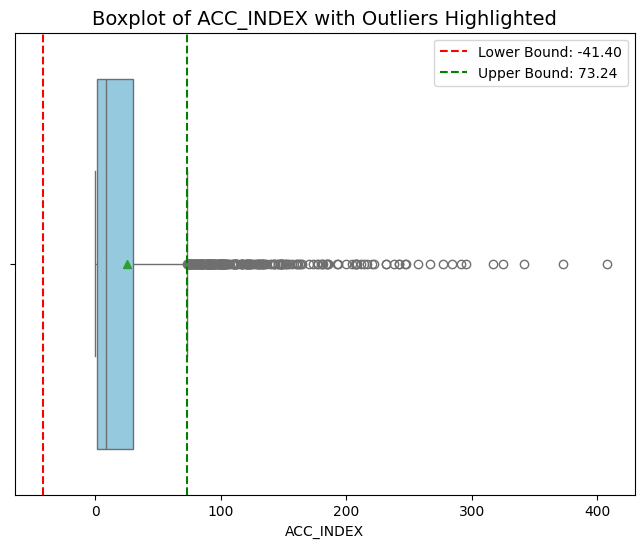

Recommended range for removing outliers in 'ACC_INDEX':
Lower Bound: -41.40, Upper Bound: 73.24


POP_2018           city      MAINUSE  TAZAREA  SUMACCIDEN  DEAD  \
4            0       קרית אתא    Open Area   508601          46     2   
7         1737  תל אביב - יפו  Residential   230938          64     1   
14        1997  תל אביב - יפו  Residential   200117          65     0   
34           0           חיפה        Other   164029          22     2   
39         970  תל אביב - יפו  Residential   188991          77     1   
...        ...            ...          ...      ...         ...   ...   
2168         0  תל אביב - יפו        Other   247256          29     1   
2189      2608  תל אביב - יפו  Residential   408782          63     1   
2193     10478          בת ים  Residential   289466          56     0   
2227      8121        ירושלים  Residential   402376          42     4   
2239         0            נשר     Industry   297854          28     0   

      SEVER_INJ  SLIGH_INJ  PEDESTRINJ  INJ0_19  ...  TOTDRIVERS  MOTORCYCLE  \
4            13        112           0       19  ...         101           1   
7            16         62           5        3  ...         134          17   
14           11         66          27       28  ...         111          20   
34            5         21           9        1  ...          32           0   
39           13         81          21        7  ...         148          33   
...         ...        ...         ...      ...  ...         ...         ...   
2168          5         41           1        3  ...          56           7   
2189         10         62          27       13  ...          99           7   
2193          8         59          27        7  ...          86           9   
2227          9         35          25       12  ...          57           2   
2239          3         57           7       10  ...          57           1   

      TRUCK  BICYCLE  PRIVATE  VEHICLE  ACC_INDEX  Shape_Length  \
4         2        0       54       83     90.444   3692.333819   
7         0        2       48       98    277.130   1966.358977   
14        0        6       35       89    324.810   1981.948449   
34        1        0       16       27    134.122   1855.790845   
39        2       14       33      111    407.426   1819.914576   
...     ...      ...      ...      ...        ...           ...   
2168      0        3       27       48    117.287   2344.999064   
2189      2        4       23       72    154.116   2873.727150   
2193      0        2       23       57    193.460   2945.257900   
2227      1        2       24       41    104.380   3457.362088   
2239      1        0       34       45     94.006   2942.353317   

         Shape_Area  RISK_LEVEL  
4     508601.257333        High  
7     230938.163403        High  
14    200116.826412        High  
34    164029.211697        High  
39    188991.454256        High  
...             ...         ...  
2168  247256.349160        High  
2189  408782.396139        High  
2193  289465.743115        High  
2227  402375.740098        High  
2239  297853.622301        High  

[220 rows x 22 columns]

In [58]:
find_outliers_with_plot(df, 'ACC_INDEX')

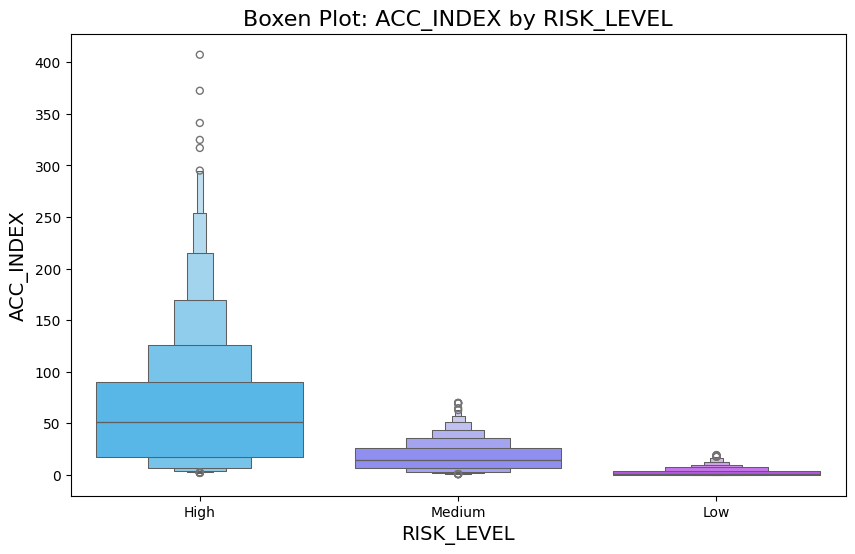

In [59]:
plot_boxen(df, 'RISK_LEVEL', 'ACC_INDEX', palette='cool', figsize=(10, 6))

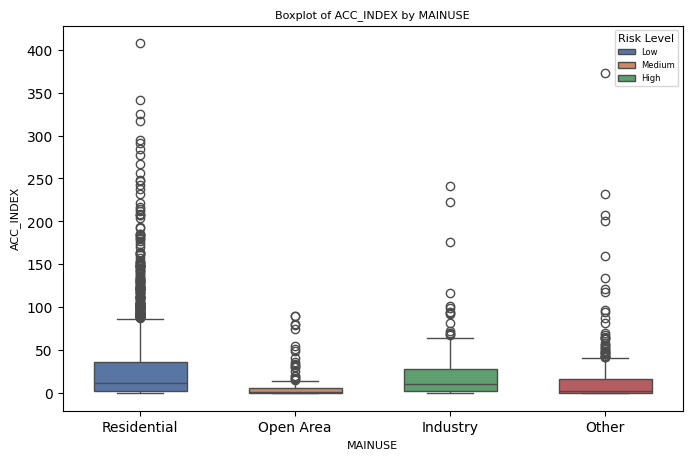

In [60]:
plot_boxplot(df, 'MAINUSE', 'ACC_INDEX', figsize=(8, 5), title=None)

### Conclusion on ACC_INDEX Analysis

Higher **ACC_INDEX** values are strongly linked to **High** risk levels, especially in residential and industrial areas, indicating greater accident density in these zones. Occasional high values in open areas may signal specific hazardous locations. 

Based on this analysis, extreme **ACC_INDEX** values should be retained, as they provide critical insights for identifying high-risk areas.


# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Correlation Analysis Approach

In [61]:
# רשימת העמודות הכמותיות לביצוע הקורלציה
numeric_columns = ['ACC_INDEX', 'PRIVATE', 'POP_2018', 'TAZAREA', 'DEAD', 'SEVER_INJ', 'SLIGH_INJ', 'Shape_Length', 'Shape_Area','VEHICLE','TOTDRIVERS']

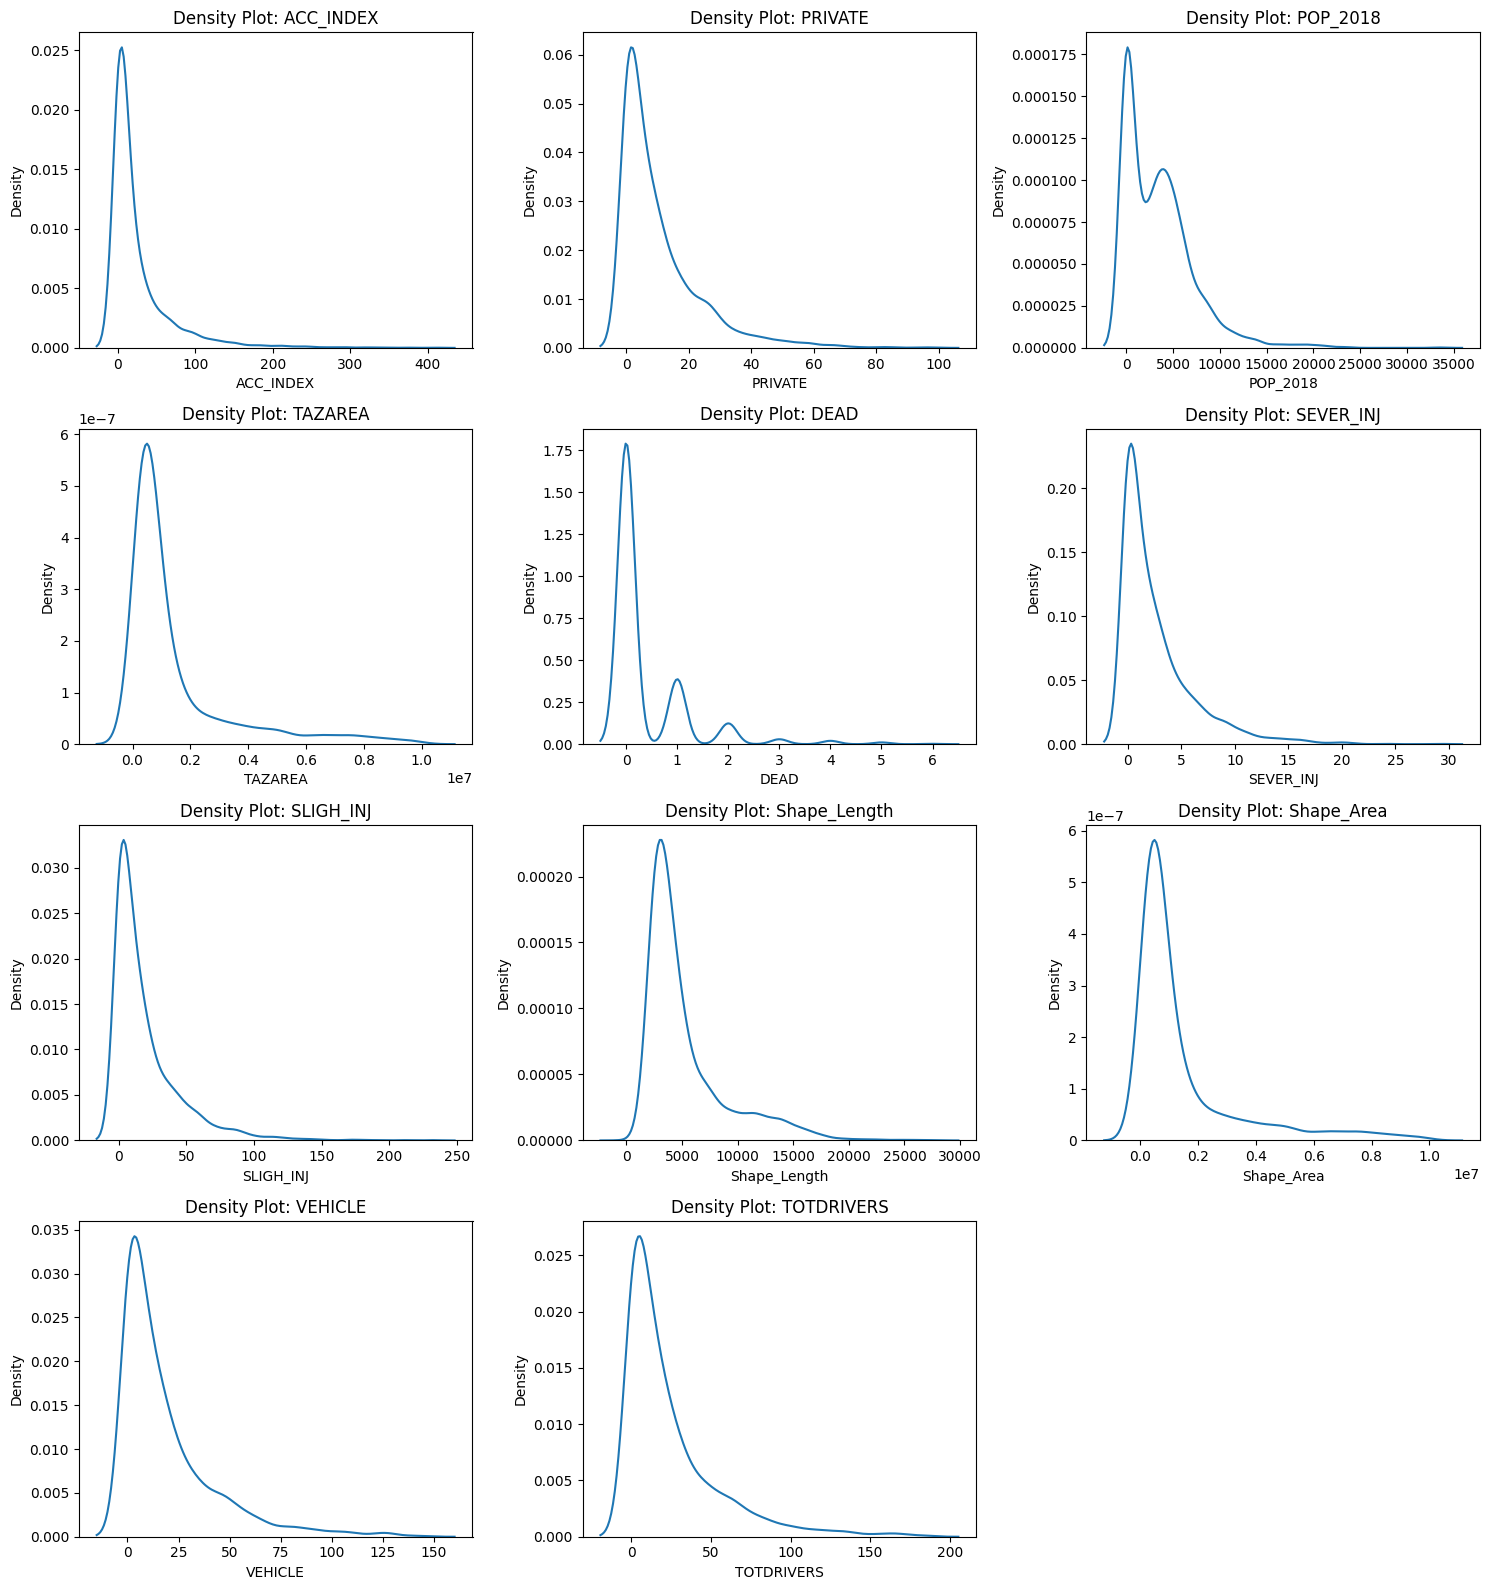

In [62]:
plot_density_plots(df, columns=numeric_columns, n_cols=3)

In this analysis, we chose to use **Kendall Tau correlation** instead of Pearson or Spearman correlation. Since the data does not follow a normal distribution and may include tied values (i.e., identical values across multiple observations), Kendall Tau provides a more robust measure of association. It is particularly suitable for datasets with potential outliers and long-tailed distributions, offering reliable insights into the monotonic relationships between variables.

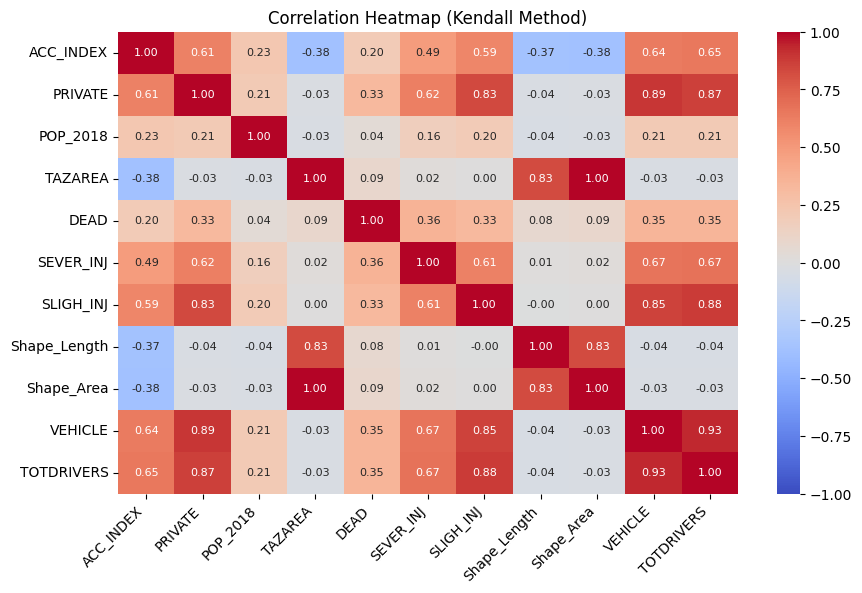

In [63]:
# רשימת העמודות הכמותיות לביצוע הקורלציה
numeric_columns = ['ACC_INDEX', 'PRIVATE', 'POP_2018', 'TAZAREA', 'DEAD', 'SEVER_INJ', 'SLIGH_INJ', 'Shape_Length', 'Shape_Area','VEHICLE','TOTDRIVERS']

# הצגת קורלציה באמצעות heatmap
plot_correlation_heatmap(df, numeric_columns, method='kendall')


### **Removing Highly Correlated Columns**

1. **`VEHICLE` and `TOTDRIVERS`**:  
   - There is a very strong positive correlation (**0.93**) between `VEHICLE` (total number of vehicles) and `TOTDRIVERS` (total number of drivers).  
   - Since both columns provide nearly identical information, keeping both is redundant.  
   - **Decision**: Keep `VEHICLE` and remove `TOTDRIVERS`, as `VEHICLE` is a broader and more general measure.

---

2. **`Shape_Area`, `Shape_Length`, and `TAZAREA`**:  
   - There is a perfect correlation (1.0) between `Shape_Area` and `TAZAREA`, meaning they provide exactly the same information.  
   - Since both `Shape_Area` and `Shape_Length` describe similar geometric properties of the region, and given that `TAZAREA` is likely a more precise measure of the actual area size, keeping all three columns would introduce redundancy into the dataset.  
   - **Decision**: Keep only `TAZAREA` and remove both `Shape_Area` and `Shape_Length`, as `TAZAREA` provides the most relevant and precise representation of the area.

---

3. **`PRIVATE` and `VEHICLE`**:  
   - There is a high correlation (**0.88**) between `PRIVATE` and `VEHICLE`.  
   - Keeping both columns may introduce redundancy, so consider dropping one.

In [64]:
# Removing columns with perfect or very high correlation
columns_to_drop = ['TOTDRIVERS', 'Shape_Area', 'Shape_Length', 'PRIVATE']
df.drop(columns=columns_to_drop, inplace=True)

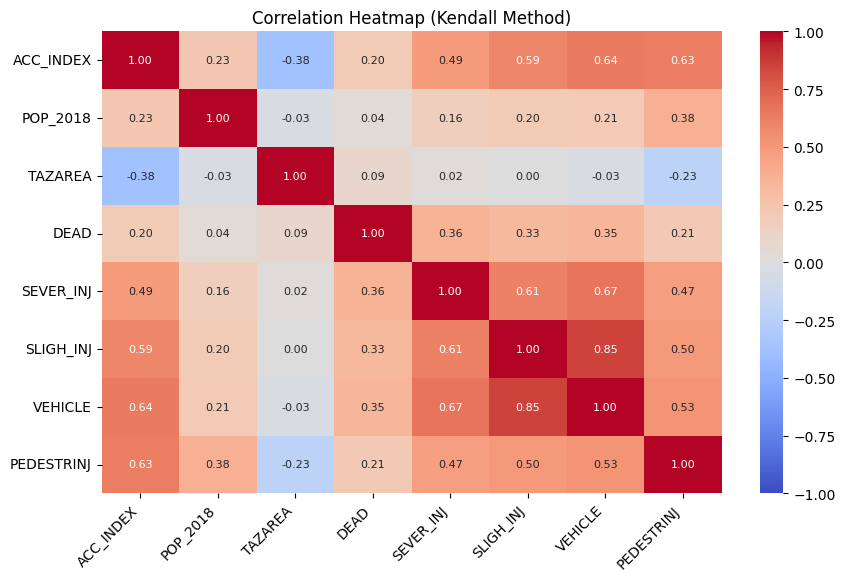

In [65]:
# רשימת העמודות הכמותיות לביצוע הקורלציה
numeric_columns = ['ACC_INDEX', 'POP_2018', 'TAZAREA', 'DEAD', 'SEVER_INJ', 'SLIGH_INJ','VEHICLE','PEDESTRINJ']
# הצגת קורלציה באמצעות heatmap
plot_correlation_heatmap(df, numeric_columns, method='kendall')

### **Key Insights from Correlation Analysis**

- **Negative Correlation between `TAZAREA` (Area Size) and `ACC_INDEX` (Accident Density Index)**:  
  A moderate negative correlation (-0.37) exists between the size of the area and the accident density. This indicates that as the size of the area increases, the accident density tends to decrease. This finding aligns with the expectation that smaller, more compact areas—such as densely populated urban regions—are prone to higher accident densities.

---

- **Positive Correlation between `VEHICLE` (Total Vehicles) and `SLIGH_INJ` (Slight Injuries)**:  
  A strong positive correlation (0.85) exists between the total number of vehicles and the number of slight injuries. This suggests that as the total number of vehicles increases, the occurrence of slight injuries also rises. This result highlights the potential impact of high vehicle volume on minor accidents, which should be considered when designing traffic management and safety improvement strategies.

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# **Feature Selection**

#### At this point, we applied **mapping** to the target column (`RISK_LEVEL`) to convert its categorical values (`Low`, `Medium`, `High`) into numerical values (`0`, `1`, `2`). This transformation is necessary since machine learning models require numerical target variables.
#### The mapping used:
- **Low** → `0`
- **Medium** → `1`
- **High** → `2`
#### Next, we divided the data into a training set and a test set to ensure proper evaluation while preventing overfitting and data leakage.

In [66]:
severity_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
df['RISK_LEVEL'] = df['RISK_LEVEL'].map(severity_mapping)

In [67]:
X = df.drop('RISK_LEVEL', axis=1)  # מסיר את עמודת המטרה
y = df['RISK_LEVEL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

X_train = X_train.replace(['', ' '], np.nan)
X_test = X_test.replace(['', ' '], np.nan)

Training set size: (1819, 17)
Test set size: (455, 17)


### Feature Selection using Statistical and Model-Based Methods

In this section, we aim to reduce dimensionality by identifying the most significant features for predicting the target variable (RISK_LEVEL). We will apply two different methods for feature selection:

1. **Chi-Square Test**  
   The Chi-Square test is a statistical method used to assess the relationship between categorical features and a categorical target variable. It measures how the observed distribution of data across different categories differs from the expected distribution under the assumption of independence.  
   - *How it works*: The test calculates the Chi-Square statistic for each feature by comparing the observed frequencies with the expected frequencies if the feature and target were independent. A high Chi-Square statistic indicates a stronger relationship between the feature and the target variable.  
   - *When to use*: The Chi-Square test is appropriate when both the feature and target variables are categorical.  
   - *Goal*: To rank categorical features by their importance and select the most significant ones for predicting RISK_LEVEL.

2. **Recursive Feature Elimination (RFE) with Random Forest**  
   RFE is a model-based feature selection technique that recursively removes the least important features based on a predictive model. In this case, we use *Random Forest* as the estimator because it is well-suited for classification tasks and can capture complex, non-linear relationships between features and the target variable.  
   - *How it works*: RFE starts with all features and recursively eliminates the least important ones based on the feature importances provided by the Random Forest model. The process continues until only the desired number of features (n_features_to_select) remains.  
   - *Why Random Forest*: Random Forest is robust, can handle high-dimensional data, and is less sensitive to outliers compared to other models. Additionally, it provides feature importance scores, making it ideal for RFE.  
   - *Goal*: To rank all features by their importance and select the top k features that have the highest impact on predictive models.

In [68]:
numerical_columns = ['ACC_INDEX', 'POP_2018', 'TAZAREA', 'DEAD', 'SEVER_INJ', 'SLIGH_INJ','VEHICLE','PEDESTRINJ', 'INJ0_19', 'INJ20_64', 'INJ65_','MOTORCYCLE', 'TRUCK', 'BICYCLE']
categorical_columns = ['MAINUSE']

Selected 10 features using RFE with Random Forest:
['ACC_INDEX', 'POP_2018', 'TAZAREA', 'SEVER_INJ', 'SLIGH_INJ', 'VEHICLE', 'PEDESTRINJ', 'INJ0_19', 'INJ20_64', 'INJ65_']


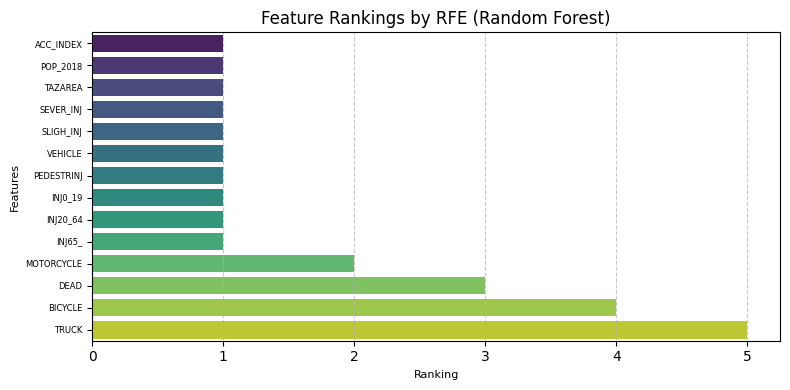

In [69]:
selected_features_rf = perform_rfe_rf(X_train[numerical_columns], y_train, n_features=10)

In [70]:
target_column = 'RISK_LEVEL'
# קריאה לפונקציה
chi_square_results = chi_square_test(df, categorical_columns, target_column)

display(chi_square_results.style.set_caption("Chi-Square Test Results (Precise P-value)").set_table_styles(
    [{'selector': 'caption', 'props': [('font-size', '16px'), ('text-align', 'center')]}]
))

The chi-square test results indicate a statistically significant association between the `MAINUSE` feature and the `RISK_LEVEL` (p-value < 0.05). This suggests that the type of main use (`MAINUSE`) is likely to influence or be associated with the level of risk (`RISK_LEVEL`). Therefore, `MAINUSE` is an important feature for further analysis or modeling.

Class  Count  Percentage (%)
0      0    853       37.510994
1      1    761       33.465259
2      2    660       29.023747

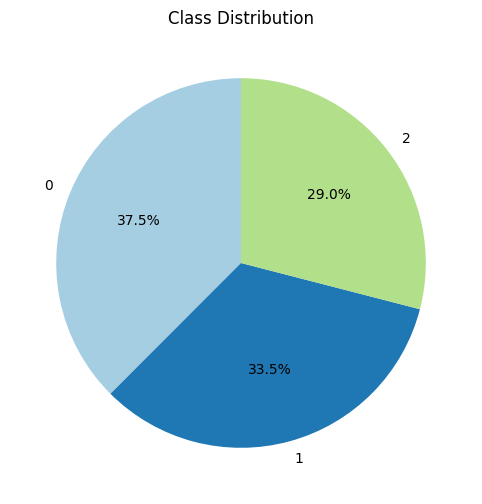

In [71]:
# Example usage:
plot_class_distribution(df, 'RISK_LEVEL')

### Class Distribution

The class distribution in the dataset is relatively balanced, with proportions of 37.6%, 33.5%, and 28.9% for each class, respectively. This balance reduces the need for special techniques to handle class imbalance and allows the use of standard classification approaches.

In [72]:
selected_features = ['ACC_INDEX', 'POP_2018', 'TAZAREA', 'SEVER_INJ', 'SLIGH_INJ', 'VEHICLE', 'PEDESTRINJ', 'INJ0_19', 'INJ20_64', 'INJ65_','MAINUSE']
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [73]:

numeric_columns = X_train_selected.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = X_train_selected.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler',RobustScaler())                   
])


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))  
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),  
        ('cat', categorical_transformer, categorical_columns)  
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

pipeline.fit(X_train_selected)
encoded_columns = pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_columns)
final_columns = numeric_columns + list(encoded_columns)


X_train_transformed = pipeline.transform(X_train_selected)
X_train_transformed = pd.DataFrame(X_train_transformed, columns=final_columns, index=X_train_selected.index)

#
X_test_transformed = pipeline.transform(X_test_selected)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=final_columns, index=X_test_selected.index)


print("Transformed Training Data:")
display(X_train_transformed.head())

print("Transformed Testing Data:")
display(X_test_transformed.head())

Transformed Training Data:


ACC_INDEX  POP_2018   TAZAREA  SEVER_INJ  SLIGH_INJ   VEHICLE  \
1337  -0.142955 -0.193862  0.028976      -0.25  -0.333333 -0.291667   
921   -0.181691 -0.561772 -0.042043      -0.25  -0.375000 -0.375000   
266    0.339614  0.991647  0.270656       1.00   0.500000  0.333333   
885    0.094298 -0.079643 -0.010134       0.50  -0.250000 -0.083333   
1646  -0.050970 -0.063326  0.315718       0.00  -0.208333 -0.125000   

      PEDESTRINJ   INJ0_19  INJ20_64  INJ65_  MAINUSE_Industry  \
1337         0.4 -0.333333 -0.444444    0.25               0.0   
921         -0.2 -0.333333 -0.333333   -0.25               1.0   
266          3.0  2.666667  0.111111   -0.25               0.0   
885          0.2  0.166667 -0.277778    0.25               0.0   
1646         0.0 -0.166667 -0.222222    0.25               0.0   

      MAINUSE_Open Area  MAINUSE_Other  MAINUSE_Residential  
1337                0.0            0.0                  1.0  
921                 0.0            0.0                  0.0  
266                 0.0            0.0                  1.0  
885                 0.0            0.0                  1.0  
1646                0.0            0.0                  1.0

Transformed Testing Data:


ACC_INDEX  POP_2018   TAZAREA  SEVER_INJ  SLIGH_INJ   VEHICLE  \
2499  -0.301614 -0.561772 -0.092217      -0.25  -0.458333 -0.458333   
110   -0.055983 -0.484266  3.181757       0.75   1.708333  1.500000   
2087   1.329150 -0.561772  0.636561       3.00   5.333333  2.916667   
742    0.385291  0.227855 -0.109414       0.50   0.041667  0.250000   
1771   0.775945 -0.233877 -0.365748      -0.25   0.000000  0.041667   

      PEDESTRINJ   INJ0_19  INJ20_64  INJ65_  MAINUSE_Industry  \
2499        -0.2 -0.333333 -0.444444   -0.25               0.0   
110         -0.2  1.000000  2.055556    0.50               0.0   
2087         1.2  5.500000  5.555556    2.50               1.0   
742          0.6  0.333333  0.166667    0.00               0.0   
1771         0.4  0.666667 -0.277778    0.00               0.0   

      MAINUSE_Open Area  MAINUSE_Other  MAINUSE_Residential  
2499                1.0            0.0                  0.0  
110                 0.0            0.0                  1.0  
2087                0.0            0.0                  0.0  
742                 0.0            0.0                  1.0  
1771                0.0            0.0                  1.0

In [74]:
# Evaluate models and get predictions
results_df, y_train_pred, y_test_pred = evaluate_models_with_cv(X_train_transformed, y_train, X_test_transformed, y_test)

# Display results including best parameters
print("Model Evaluation Results with Best Parameters:")
display(results_df)


Model Evaluation Results with Best Parameters:


Model  Precision    Recall  F1-Score  Accuracy  \
0    Gradient Boosting   0.937528  0.936264  0.936473  0.936264   
1                  SVM   0.936376  0.936264  0.936268  0.936264   
2  Logistic Regression   0.933871  0.934066  0.933891  0.934066   
3        Random Forest   0.930628  0.929670  0.929891  0.929670   
4                  kNN   0.892348  0.892308  0.891563  0.892308   

                                         Best Params  
0  {'learning_rate': 0.2, 'max_depth': 7, 'n_esti...  
1                         {'C': 10, 'kernel': 'rbf'}  
2                                          {'C': 10}  
3           {'max_depth': None, 'n_estimators': 100}  
4                                 {'n_neighbors': 5}

Top 10 Features by Importance:


Feature  Importance
5     VEHICLE    0.761929
4   SLIGH_INJ    0.105149
0   ACC_INDEX    0.049298
6  PEDESTRINJ    0.045897
2     TAZAREA    0.010057
3   SEVER_INJ    0.009010
8    INJ20_64    0.008308
1    POP_2018    0.005578
9      INJ65_    0.003437
7     INJ0_19    0.000995

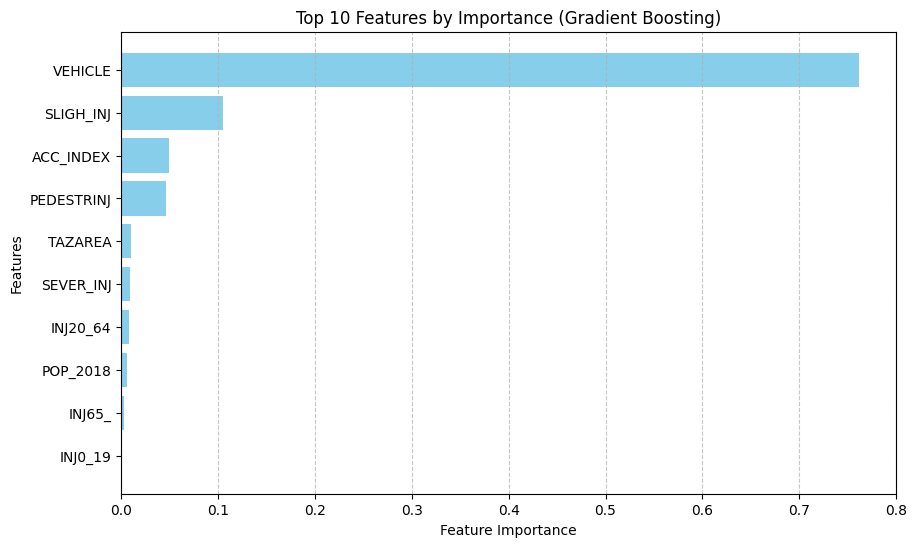

In [75]:
### CODE BY GPT### 
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_transformed, y_train)

feature_importances = pd.DataFrame({
    'Feature': X_train_transformed.columns,
    'Importance': gb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Top 10 Features by Importance:")
display(feature_importances.head(10))
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'][:10], feature_importances['Importance'][:10], color='skyblue')
plt.gca().invert_yaxis()  
plt.title("Top 10 Features by Importance (Gradient Boosting)")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()
###

### **Key Conclusions and Model Selection Rationale**

#### **1. Model Performance**  
The **Gradient Boosting** model demonstrated the best overall performance, showing superior accuracy and F1-Score compared to other models. **SVM** and **Logistic Regression** also achieved high performance, making them competitive alternatives. **Random Forest** showed solid results but was slightly less effective than Gradient Boosting. The **kNN** model lagged behind, indicating that it may not be well-suited for this dataset.

#### **2. Feature Importance Analysis**  
The feature importance analysis highlighted **VEHICLE** as the most influential feature, suggesting that the number of vehicles significantly impacts accident risk prediction. Other important features included **SLIGH_INJ** and **ACC_INDEX**, reinforcing their relevance in identifying high-risk areas. Demographic and area-based features, such as **TAZAREA** and **POP_2018**, were found to have minimal influence.

#### **3. Considerations for Choosing a Model**  
In road accident risk prediction, misclassifying high-risk areas as low-risk can lead to delayed safety interventions, increasing the likelihood of severe accidents. Therefore, we prioritized **Recall** to ensure that high-risk areas were correctly identified, even at the expense of some false positives. Based on this priority and its superior performance, **Gradient Boosting** was selected as the final model due to its ability to handle complex patterns and outliers effectively.

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Unsupervised

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### **Function in use**

In [99]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import cdist

### CODE BY GPT### 
def evaluate_clustering(data, k_values=range(2, 9)):
    results = {'Clusters': [], 'Inertia': [], 'Silhouette': [], 'Min Cluster Size': [], 'Max Cluster Size': []}
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k,init='k-means++', random_state=42, n_init=10).fit(data)
        labels = kmeans.labels_
        inertia = kmeans.inertia_  
        silhouette_avg = silhouette_score(data, labels)  
        cluster_sizes = pd.Series(labels).value_counts()
        min_cluster_size = cluster_sizes.min()
        max_cluster_size = cluster_sizes.max()
        results['Clusters'].append(k)
        results['Inertia'].append(inertia)
        results['Silhouette'].append(silhouette_avg)
        results['Min Cluster Size'].append(min_cluster_size)
        results['Max Cluster Size'].append(max_cluster_size)
        print(f"Silhouette score for {k} clusters: {silhouette_avg:.4f}")
    
    results_df = pd.DataFrame(results)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(results['Clusters'], results['Inertia'], marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(results['Clusters'], results['Silhouette'], marker='o', color='orange')
    plt.title('Silhouette Scores')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return results_df
###

### CODE BY GPT### 
def plot_silhouette_subplots(data, k_range=range(2, 10), title="Silhouette Analysis", cmap=cm.nipy_spectral):
    fig, axes = plt.subplots(3, 3, figsize=(20, 15)) 
    axes = axes.flatten()
    silhouette_scores = []  
    for idx, k in enumerate(k_range):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append((k, silhouette_avg))
        sample_silhouette_values = silhouette_samples(data, cluster_labels)
        ax = axes[idx]
        ax.set_xlim([-0.1, 1])
        ax.set_ylim([0, len(data) + (k + 1) * 10])
        y_lower = 10
        for i in range(k):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cmap(float(i) / k)
            ax.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7
            )
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        ax.set_title(f"Silhouette plot for {k} clusters")
        ax.set_xlabel("Silhouette coefficient values")
        ax.set_ylabel("Cluster label")
    for i in range(len(k_range), len(axes)):
        fig.delaxes(axes[i])
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()
    print("Silhouette scores for different numbers of clusters:")
    for k, score in silhouette_scores:
        print(f"K={k}: Silhouette score={score:.4f}")
###

def perform_pca(data, n_components=None):
    pca = PCA(n_components=n_components)
    transformed_data = pca.fit_transform(data)
    
    explained_variance = pca.explained_variance_ratio_.cumsum()
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
    plt.title('Cumulative Explained Variance by PCA Components')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()
    
    return transformed_data, pca


def plot_dendrogram_colored(data, method='ward', truncate_mode=None, p=12, color_threshold=None):
    linked = linkage(data, method=method) 
    plt.figure(figsize=(10, 7))
    dendrogram(
        linked,
        truncate_mode='lastp',  
        p=p,                          
        leaf_rotation=90,
        leaf_font_size=10,
        show_contracted=True,
        color_threshold=color_threshold if color_threshold else 0.7 * max(linked[:, 2]), 
    )
    plt.title('Hierarchical Clustering Dendrogram', fontsize=16)
    plt.xlabel('Sample Index or Cluster Size', fontsize=12)
    plt.ylabel('Distance', fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    if truncate_mode is None:
        plt.xticks([], [])  
    plt.show()

def visualize_clusters_2d(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data)
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=labels, palette='viridis', s=50)
    plt.title(f'2D Visualization of Clusters (k={n_clusters})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

### CODE BY GPT### 
def analyze_original_feature_contribution(data_pca, pca_model, k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_pca)
    data_with_clusters = pd.DataFrame(data_pca, columns=[f'PC{i+1}' for i in range(data_pca.shape[1])])
    data_with_clusters['cluster'] = labels
    cluster_means = data_with_clusters.groupby('cluster').mean().values
    original_feature_contribution = np.dot(cluster_means, pca_model.components_)
    plt.figure(figsize=(12, 6))
    sns.heatmap(original_feature_contribution, annot=True, cmap='coolwarm', cbar=True, 
                xticklabels=pca_model.feature_names_in_, yticklabels=[f'Cluster {i}' for i in range(k)])
    plt.title(f'Original Feature Contribution by {k} Clusters')
    plt.xlabel('Original Features')
    plt.ylabel('Clusters')
    plt.show()

###


In [100]:
df_processed = pipeline.transform(df)
preprocessor = pipeline.named_steps['preprocessor']

numeric_features = preprocessor.transformers_[0][2]
categorical_features = preprocessor.transformers_[1][1].get_feature_names_out(preprocessor.transformers_[1][2])
all_columns = list(numeric_features) + list(categorical_features)
df_processed = pd.DataFrame(df_processed, columns=all_columns)
df_processed.head()

ACC_INDEX  POP_2018   TAZAREA  SEVER_INJ  SLIGH_INJ   VEHICLE  PEDESTRINJ  \
0   1.753247  1.370629  0.201378       3.25   1.375000  2.125000         5.4   
1  -0.064081  0.677156  0.766312       0.00   0.333333  0.083333         0.0   
2   1.419557  1.823038 -0.258248       0.75   0.375000  0.416667         1.8   
3   0.400189  0.475719 -0.119226       0.00  -0.083333  0.041667         0.8   
4   2.868911 -0.561772 -0.110982       3.00   4.208333  3.000000        -0.2   

    INJ0_19  INJ20_64  INJ65_  MAINUSE_Industry  MAINUSE_Open Area  \
0  1.833333  1.388889    2.50               0.0                0.0   
1  0.333333  0.444444   -0.25               0.0                0.0   
2  1.000000  0.222222    0.75               0.0                0.0   
3 -0.166667 -0.055556    0.25               0.0                0.0   
4  2.833333  4.888889    2.75               0.0                1.0   

   MAINUSE_Other  MAINUSE_Residential  
0            0.0                  1.0  
1            0.0                  1.0  
2            0.0                  1.0  
3            0.0                  1.0  
4            0.0                  0.0

#### In this step, we will apply the KMeans algorithm on the dataset for a range of cluster values (K) from 2 to 9.  
#### We will evaluate the clusters using two methods:  
1. **The Elbow Method** – to analyze the inertia and identify the point where adding more clusters no longer significantly  the fit.  
 2. **The Silhouette Score** – to measure how well each data point fits within its cluster, indicating the quality of the clustering.

 The results will help us determine the optimal number of clusters for the dataset.aset.

Silhouette score for 2 clusters: 0.4891
Silhouette score for 3 clusters: 0.4700
Silhouette score for 4 clusters: 0.3494
Silhouette score for 5 clusters: 0.3588
Silhouette score for 6 clusters: 0.2843
Silhouette score for 7 clusters: 0.2816
Silhouette score for 8 clusters: 0.2595
Silhouette score for 9 clusters: 0.2627


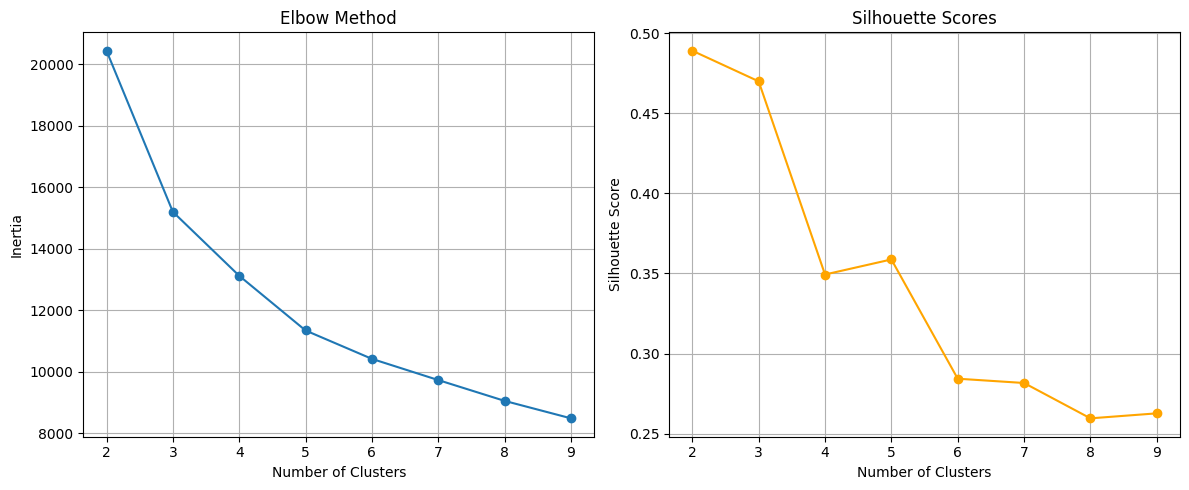

In [101]:
results_df = evaluate_clustering(df_processed, k_values=range(2, 10))


Both the Elbow Method and Silhouette Scores suggest that **2 or 3 clusters** are optimal. While 2 clusters yield the highest silhouette score, 3 clusters provide more detailed insights without adding excessive complexity.


### Further Analysis with Dimensionality Reduction

To enhance the clustering results and potentially improve the silhouette scores, we applied **Principal Component Analysis (PCA)** for dimensionality reduction. By reducing the dataset to its key components, we aimed to capture the most significant variance while minimizing noise. After applying PCA, clustering was re-evaluated, and the silhouette scores were compared to assess any improvements.


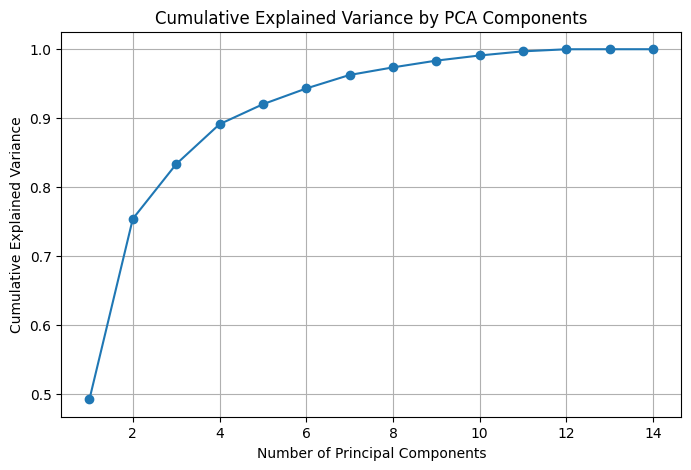

In [102]:
pca = PCA().fit(df_processed)
explained_variance = pca.explained_variance_ratio_.cumsum()
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [103]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(df_processed)

Silhouette score for 2 clusters: 0.5711
Silhouette score for 3 clusters: 0.5855
Silhouette score for 4 clusters: 0.4872
Silhouette score for 5 clusters: 0.5000
Silhouette score for 6 clusters: 0.4588
Silhouette score for 7 clusters: 0.4623
Silhouette score for 8 clusters: 0.4140
Silhouette score for 9 clusters: 0.4221


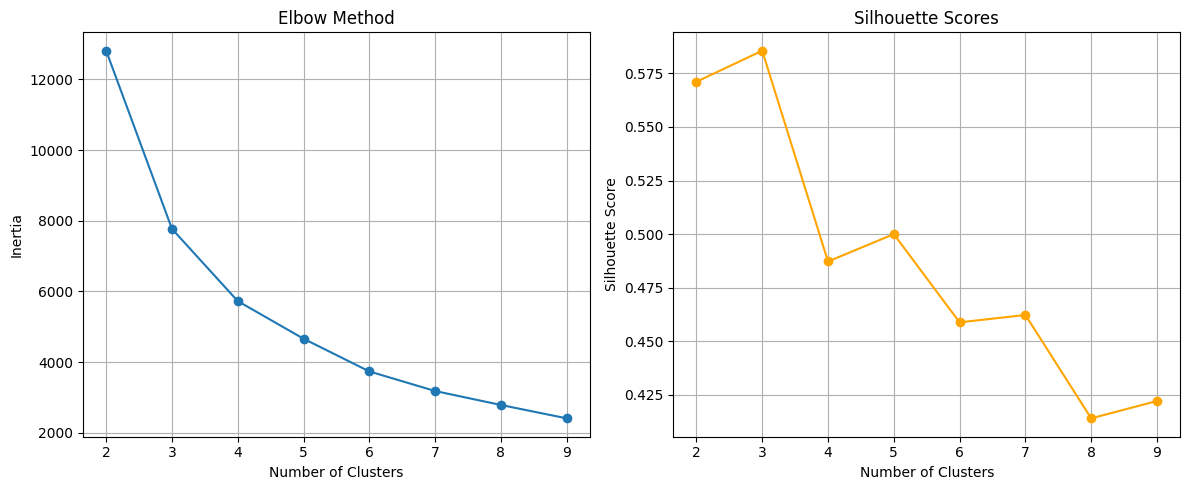

In [104]:
results_df = evaluate_clustering(data_pca, k_values=range(2, 10))

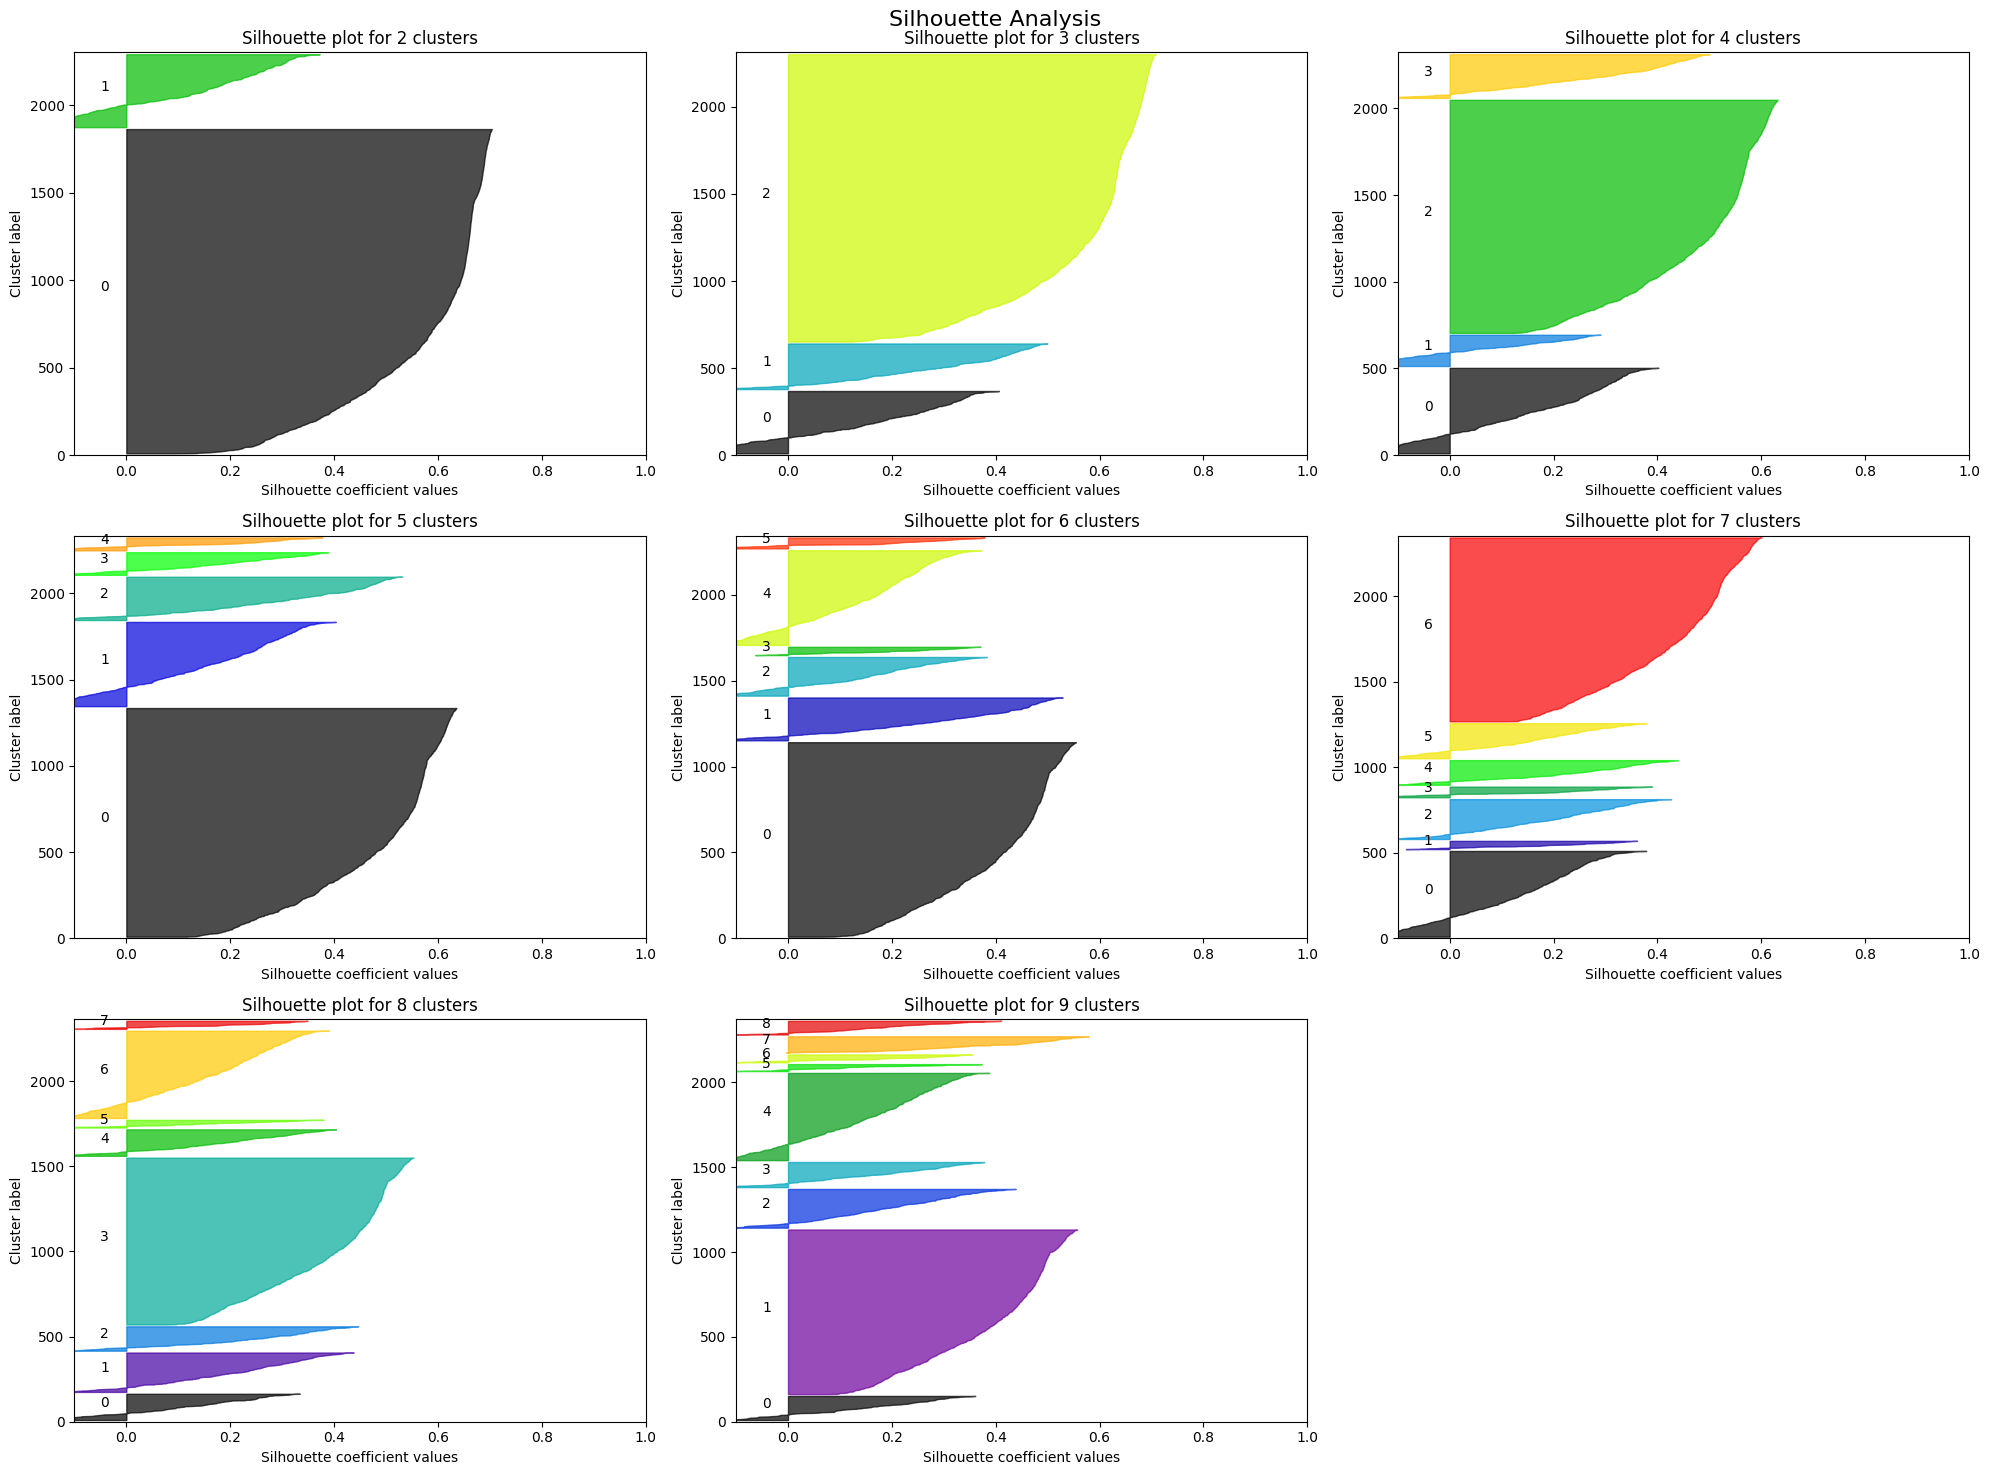

Silhouette scores for different numbers of clusters:
K=2: Silhouette score=0.4891
K=3: Silhouette score=0.4700
K=4: Silhouette score=0.3494
K=5: Silhouette score=0.3588
K=6: Silhouette score=0.2843
K=7: Silhouette score=0.2816
K=8: Silhouette score=0.2595
K=9: Silhouette score=0.2627


In [105]:
plot_silhouette_subplots(df_processed)


### Examining the silhouettes after applying PCA

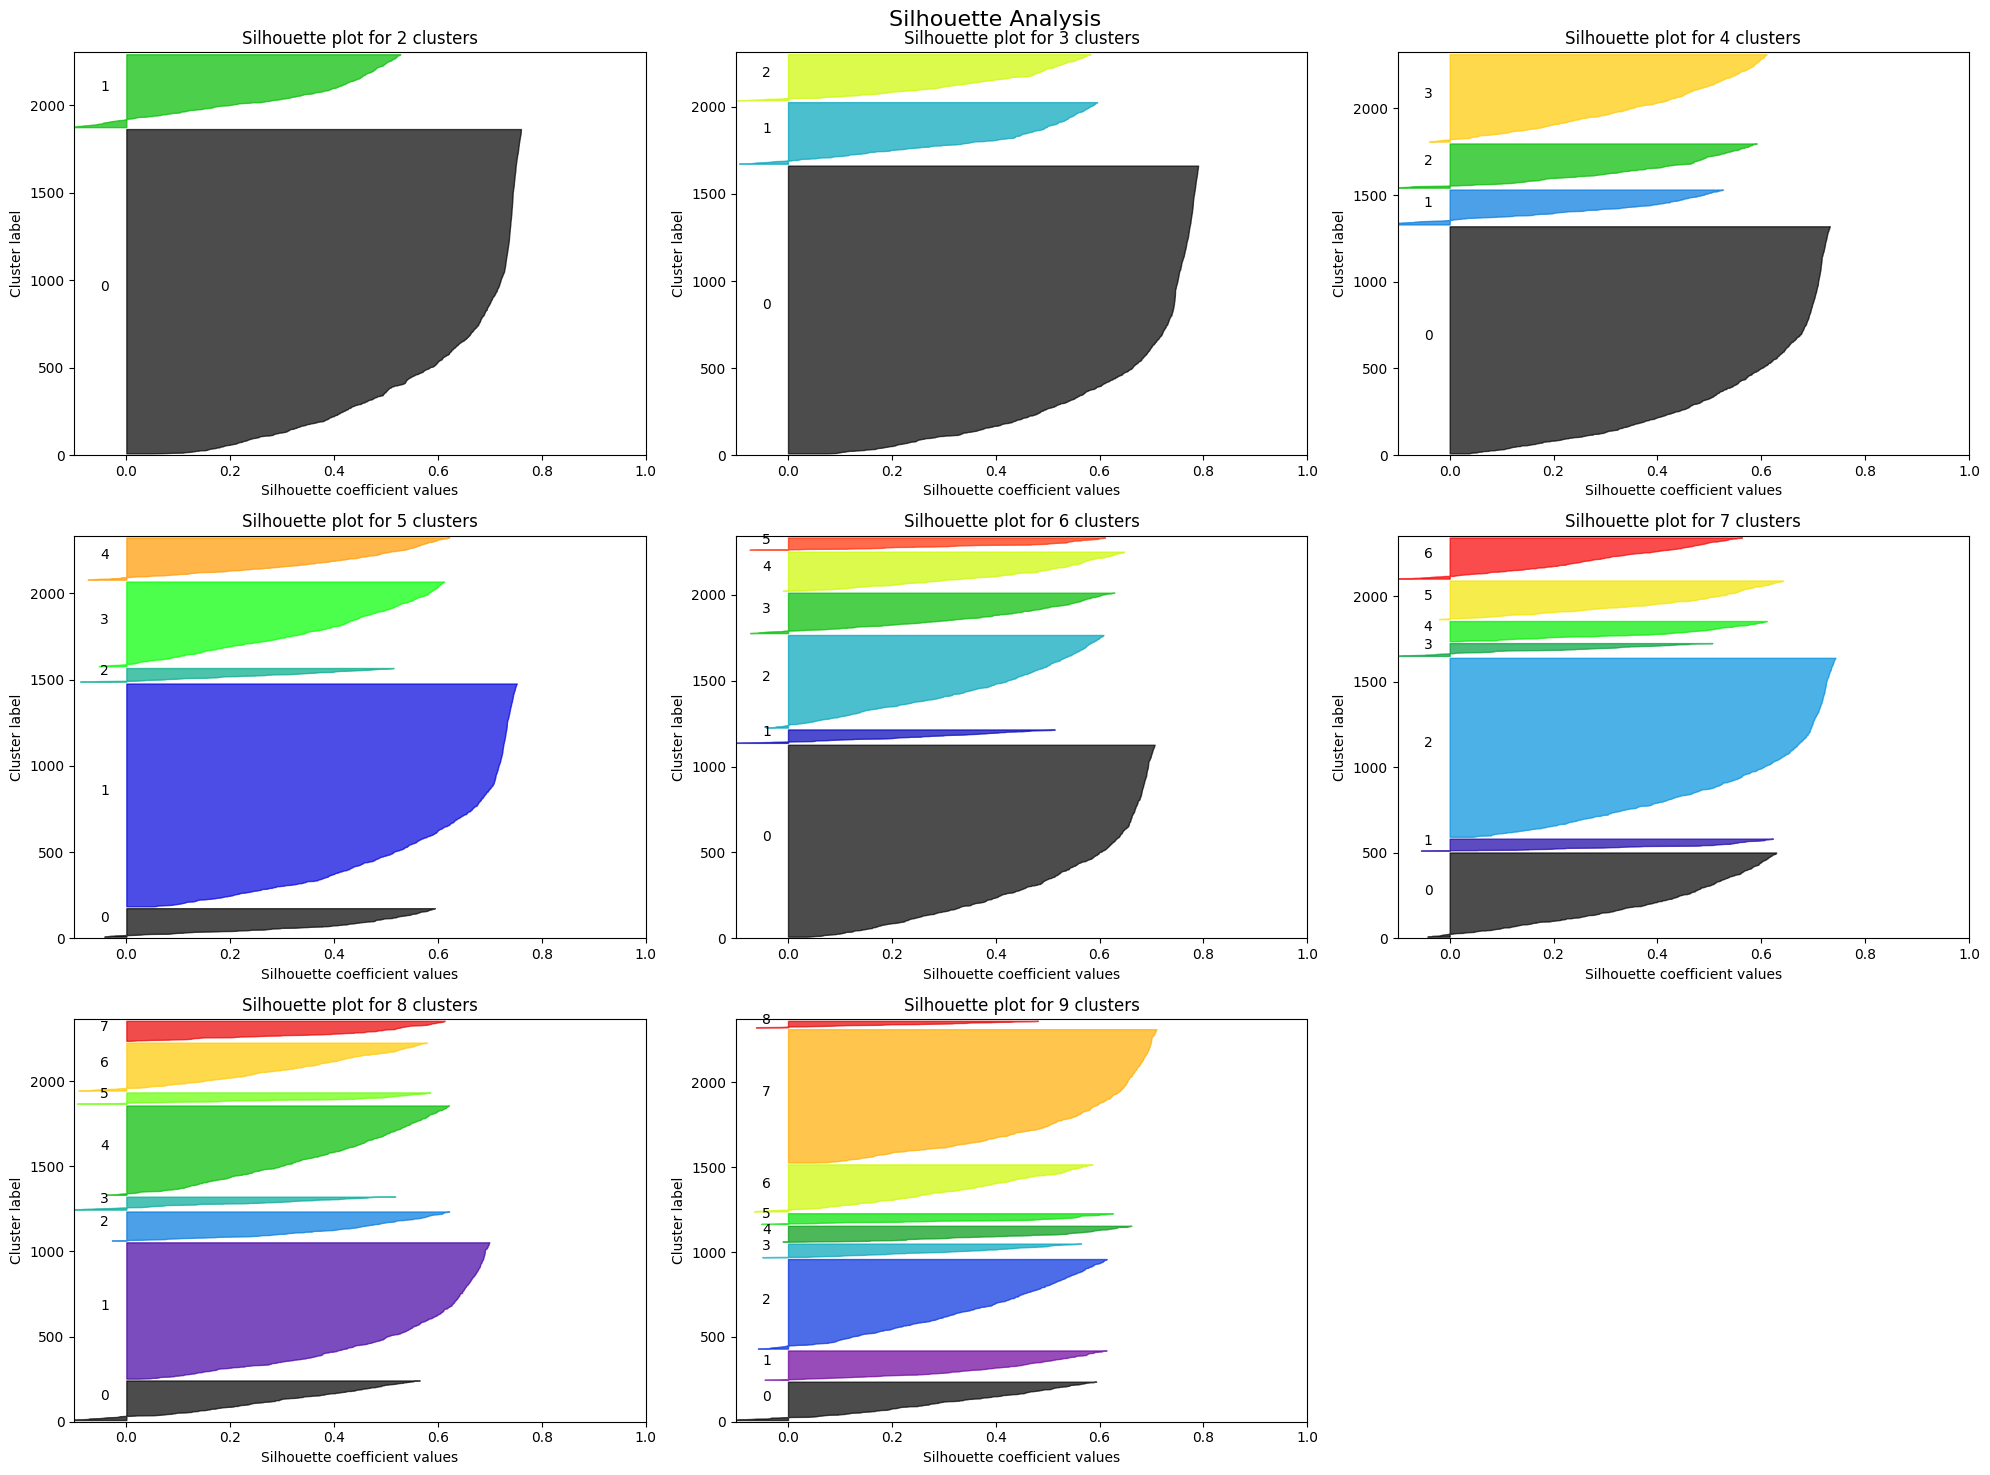

Silhouette scores for different numbers of clusters:
K=2: Silhouette score=0.5711
K=3: Silhouette score=0.5855
K=4: Silhouette score=0.4872
K=5: Silhouette score=0.5000
K=6: Silhouette score=0.4588
K=7: Silhouette score=0.4623
K=8: Silhouette score=0.4140
K=9: Silhouette score=0.4221


In [106]:
plot_silhouette_subplots(data_pca)

### Impact of PCA on Clustering Results

Applying **Principal Component Analysis (PCA)** significantly improved the silhouette scores for the clustering results. Before applying PCA, the highest silhouette score was **0.4891** for **K=2** clusters, and scores steadily declined as the number of clusters increased. After applying PCA, the silhouette score for **K=3** clusters increased to **0.5855**, indicating better-defined clusters with clearer separation.

The scores for **K=2** and **K=3** clusters were notably higher post-PCA, suggesting that dimensionality reduction helped reduce noise and emphasize meaningful patterns in the data. This improvement highlights the effectiveness of PCA in clustering tasks, particularly when dealing with high-dimensional data.


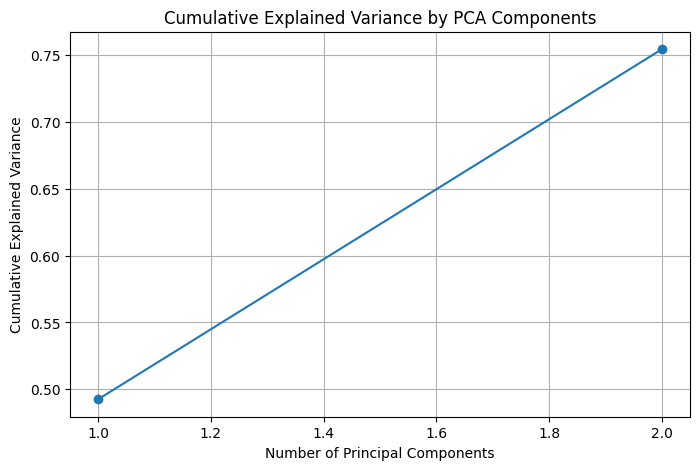

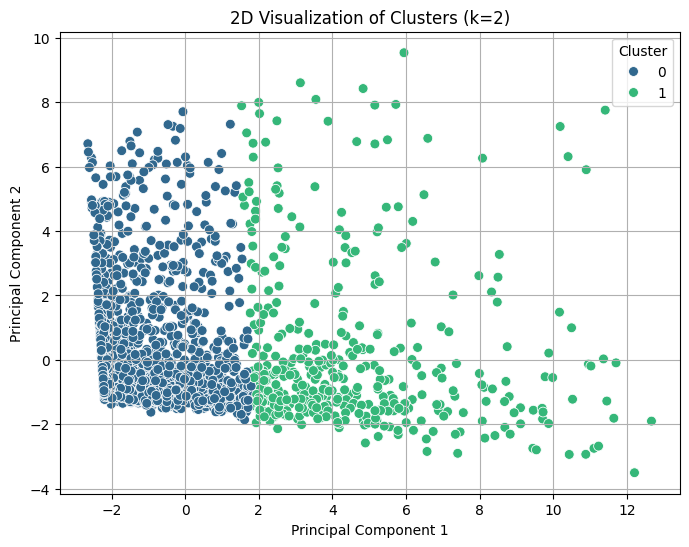

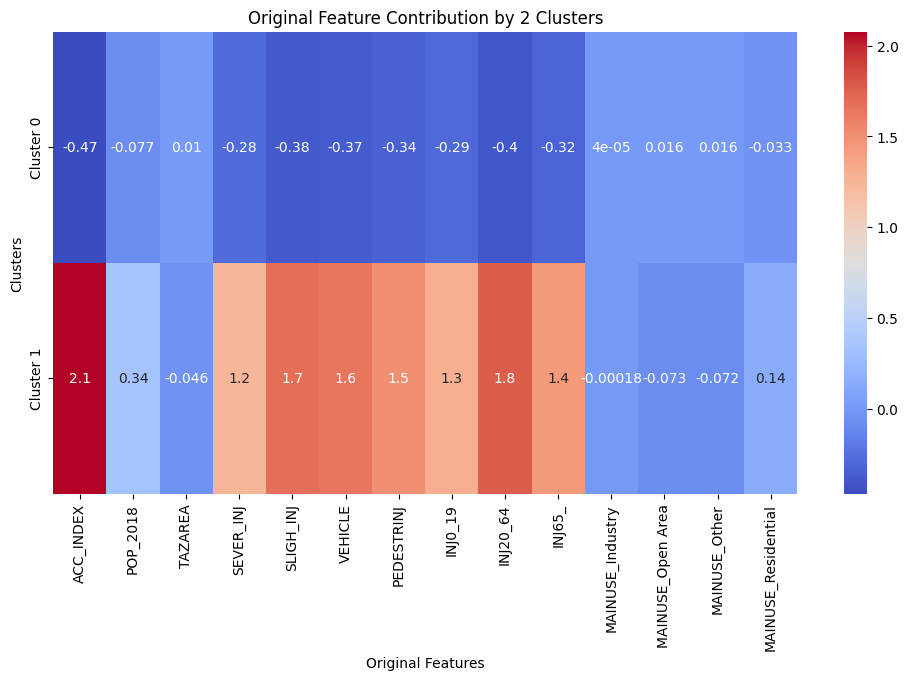

In [107]:
transformed_data, pca_model = perform_pca(df_processed, n_components=2)
visualize_clusters_2d(data_pca, n_clusters=2)
analyze_original_feature_contribution(data_pca, pca_model, k=2)

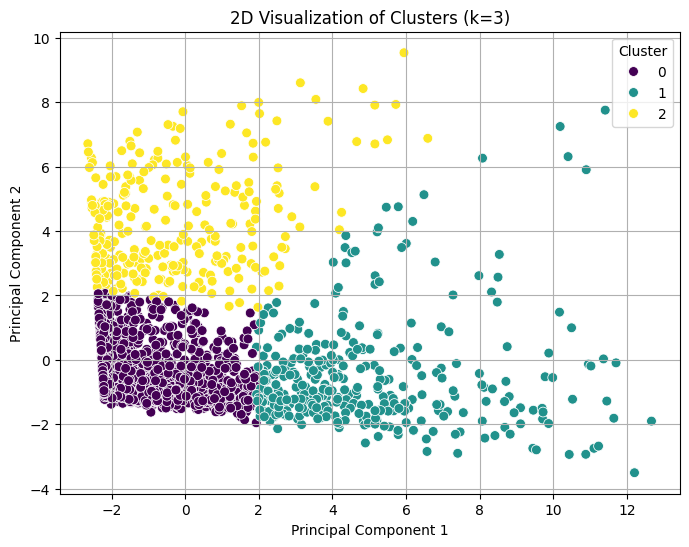

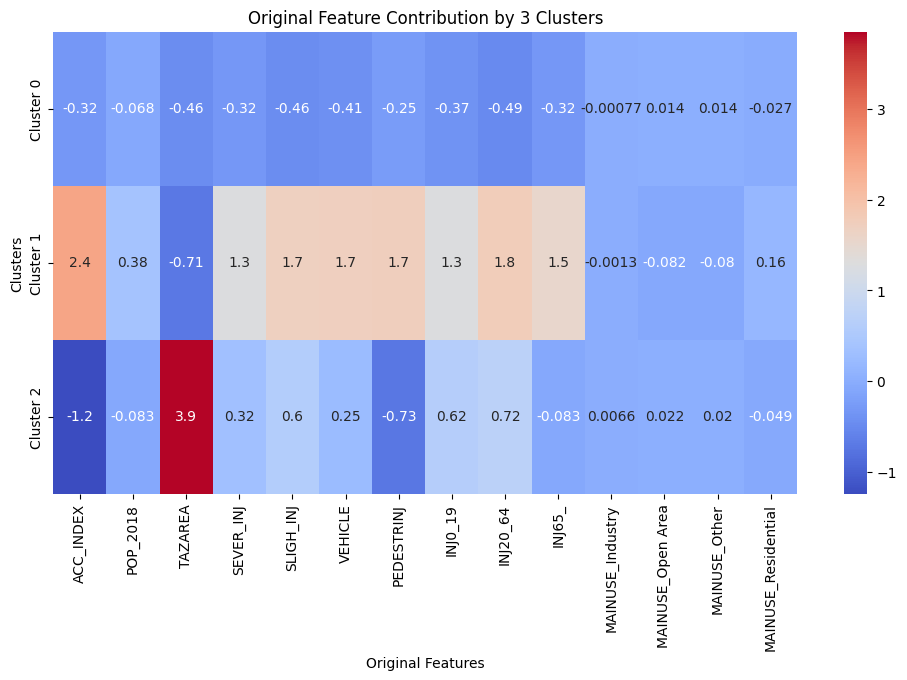

In [108]:
visualize_clusters_2d(data_pca, n_clusters=3)
analyze_original_feature_contribution(data_pca, pca_model, k=3)

# Insights from PCA and K-Means Clustering

#### Visualization and Analysis for k=2 Clusters
- The 2D visualization for **k=2 clusters** shows a clear separation between the two clusters. The clustering effectively captures the underlying structure of the data in two principal components.
- The feature contribution heatmap for **k=2 clusters** reveals that:
  - **ACC_INDEX**, **VEHICLE**, and **SEVER_INJ** are the most influential features in distinguishing between the clusters.
  - Cluster 1 is characterized by significantly higher values for these features compared to Cluster 0, indicating a higher density of accidents, more vehicles involved, and more severe injuries in this cluste##r.

## Visualization and Analysis for k=3 Clusters
- The 2D visualization for **k=3 clusters** demonstrates further subdivision of the data, with distinct clusters that capture more nuanced patterns in the dataset.
- The feature contribution heatmap for **k=3 clusters** shows:
  - **TAZAREA** (traffic zone area) plays a significant role in distinguishing Cluster 2 from the other clusters.
  - **ACC_INDEX**, **VEHICLE**, and **INJ_TOTAL** continue to have a strong influence across all clusters.
  - Cluster 1 has high values for **ACC_INDEX** and **VEHICLE**, while Cluster 2 shows a notable increase in **TAZAREA**, indicating larger traffic zones with fewer a##ccidents.

## Key Observations
1. **ACC_INDEX**, **VEHICLE**, and **SEVER_INJ** are consistently important features across both k=2 and k=3 clustering scenarios, indicating that they are key indicators of accident severity and density.
2. **TAZAREA** becomes a distinguishing feature when using **k=3 clusters**, helping to differentiate areas with larger traffic zones but potentially fewer accidents.
3. The PCA visualizations confirm that dimensionality reduction was successful, retaining key patterns and allowing for effecti##ve clustering.

## Next Steps
Given these observations, we will proceed to:
- Apply **Hierarchical Clustering** to further explore the structure of the data and validate the clustering results obtained from K-Means.
- Compare the results from K-Means and Hierarchical Clustering to assess consistency and robustness in the identified clusters.
ns.


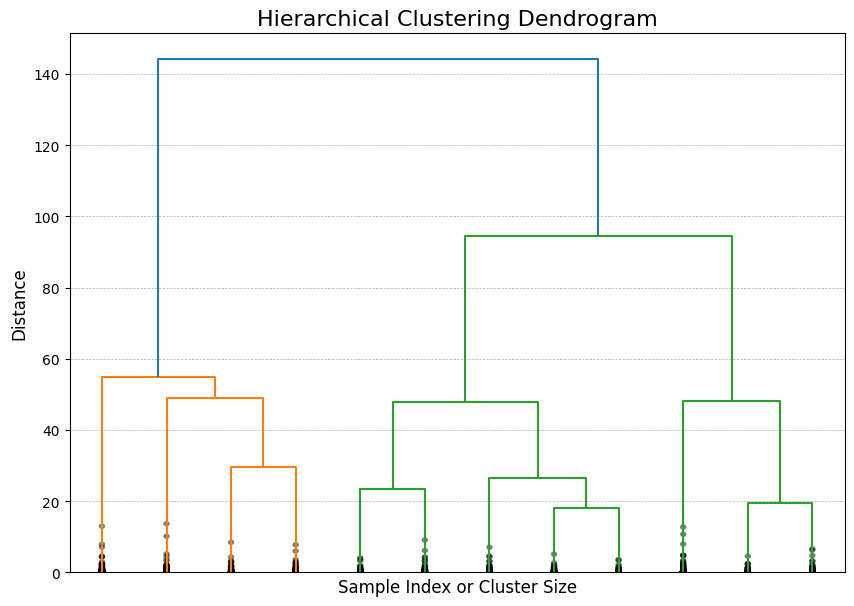

In [109]:
plot_dendrogram_colored(data_pca, method='ward')


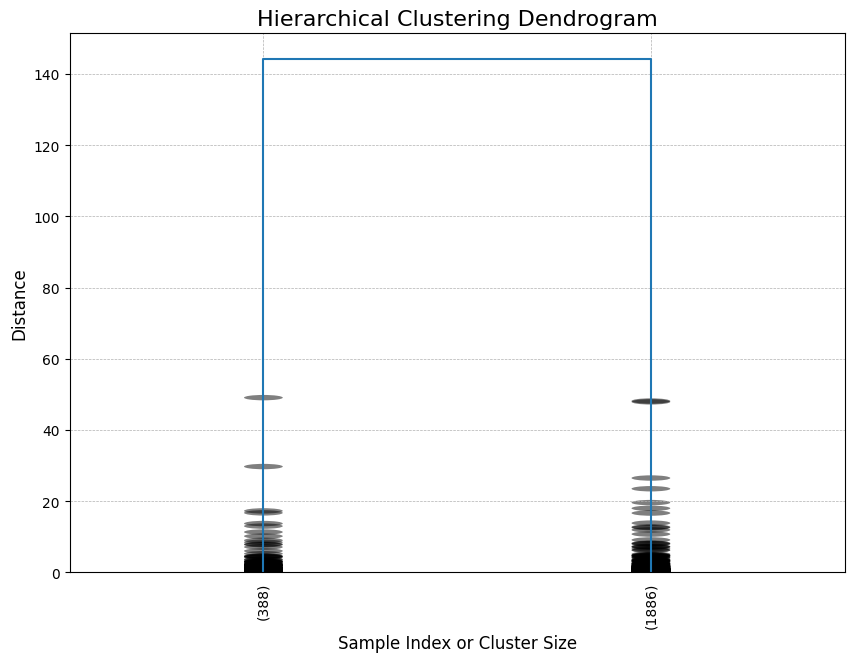

In [110]:
plot_dendrogram_colored(data_pca, method='ward', truncate_mode='lastp', p=2)

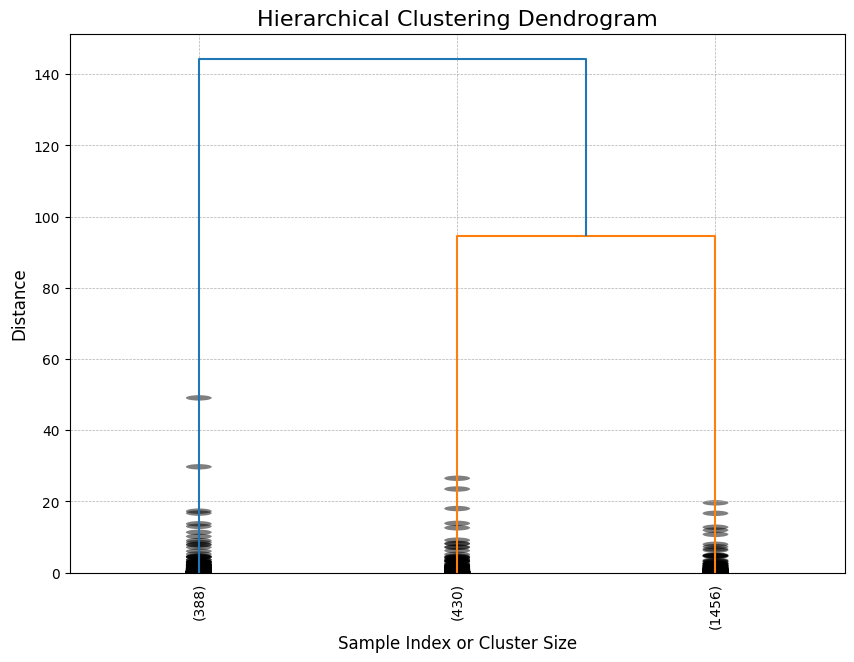

In [111]:
plot_dendrogram_colored(data_pca, method='ward', truncate_mode='lastp', p=3)

## Hierarchical Clustering Analysis – Conclusion: Selection of K=3

To determine the optimal number of clusters for the data, hierarchical clustering was applied, generating three dendrograms to explore the natural grouping. This analysis aimed to validate and complement the previous KMeans clustering results and to decide whether **K=2** or **K=3** is the most appropriate choice.
##
## General Dendrogram (No Predefined K)
- The general dendrogram revealed a clear split into **two primary clusters** at a large distance, with potential sub-clusters at lower distances.
- This observation suggested that both **K=2** and **K=3** could be reasonable options, depending on the level of granularity desi####d.

## Dendrogram for K=2
- The dendrogram for **K=2** showed a well-defined split at a large distance, indicating that K=2 effectively captures major differences in the data.
- Additionally, the previous KMeans result for **K=2** yielded a relatively high **silhouette score**, reinforcing that K=2 is a valid choice.
- However, while K=2 captures the main data structure, it may overlook finer patterns within the ####usters.

## Dendrogram for K=3
- The dendrogram for **K=3** introduced an additional level of refinement, showing a meaningful division into **three clusters**.
- The previous KMeans result for **K=3** slightly improved the **silhouette score** compared to K=2, indicating that K=3 better captures finer-grained patterns in the data.
- The additional cluster in K=3 helps distinguish between sub-groups within the primary clusters, providing more detailed segm####tation.

---

## Final Conclusion
Based on the hierarchical clustering analysis and the comparison of dendrograms, **K=3** was selected as the optimal number of clusters. This decision is supported by:
1. The **refined grouping** observed in the dendrogram for K=3.
2. The improved **silhouette score** in KMeans clustering with K=3 compared to K=2.
3. The ability of K=3 to capture **finer patterns** and provide more granular insights into the data structure.

Moving forward, **K=3** will be used for building the recommendation system, ensuring that the clusters are both meaningful and well-supported by the underlying data.
ted by the data.


# Build a recomendation system:

### Functions for this step

In [88]:
### CODE BY GPT### 
def detect_anomalies(data, labels, n_std=3):
    anomalies = []
    clusters = pd.DataFrame(data)
    clusters['Cluster'] = labels
    for cluster in clusters['Cluster'].unique():
        cluster_data = clusters[clusters['Cluster'] == cluster].drop(columns='Cluster')
        mean = cluster_data.mean()
        std = cluster_data.std()
        for index, row in cluster_data.iterrows():
            if ((row < mean - n_std * std) | (row > mean + n_std * std)).any():
                anomalies.append((index, cluster))
    print(f"Detected {len(anomalies)} anomalies across all clusters.")
    return anomalies


def cluster_summary(data, labels, original_columns=None):
    if original_columns is None or data.shape[1] != len(original_columns):
        original_columns = [f"Principal Component {i+1}" for i in range(data.shape[1])]
    clusters = pd.DataFrame(data, columns=original_columns)
    clusters['Cluster'] = labels
    summary = clusters.groupby('Cluster').mean()  
    print("Cluster Summary:")
    display(summary)
    return summary

def calculate_anomaly_distances(data, anomalies, cluster_centers):
    anomaly_indices = [anomaly[0] for anomaly in anomalies]
    distances = cdist(data[anomaly_indices], cluster_centers, metric='euclidean')
    distance_df = pd.DataFrame(distances, index=anomaly_indices, columns=[f"Cluster {i}" for i in range(cluster_centers.shape[0])])
    print("Anomaly Distances to Cluster Centers:")
    display(distance_df)
    return distance_df
###
def plot_clusters_with_anomalies(data, labels, anomalies):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=labels, palette='viridis', s=100, alpha=0.7, legend='full')
    anomaly_indices = [anomaly[0] for anomaly in anomalies]
    plt.scatter(data[anomaly_indices, 0], data[anomaly_indices, 1], color='red', label='Anomalies', edgecolor='black', s=150)
    plt.title("Clusters with Anomalies Highlighted")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

def plot_feature_contributions(cluster_means):
    plt.figure(figsize=(12, 8))
    sns.heatmap(cluster_means, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
    plt.title("Feature Contributions to Clusters")
    plt.xlabel("Features")
    plt.ylabel("Clusters")
    plt.show()


def create_anomaly_table(data, labels, anomalies):
    anomaly_indices = [anomaly[0] for anomaly in anomalies]
    anomaly_clusters = [labels[index] for index in anomaly_indices]
    
    anomaly_table = pd.DataFrame({
        'Index': anomaly_indices,
        'Cluster': anomaly_clusters
    }) 
    return anomaly_table

In [89]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_pca) 
labels = kmeans.labels_

In [90]:
clusters_with_features = df_processed.copy()  
clusters_with_features['Cluster'] = labels    
cluster_means = clusters_with_features.groupby('Cluster').mean()  
display(cluster_means)


ACC_INDEX  POP_2018   TAZAREA  SEVER_INJ  SLIGH_INJ   VEHICLE  \
Cluster                                                                  
0         0.189448  0.031652  0.233169   0.099758  -0.065548 -0.063231   
1         3.105589  0.458580  0.102923   1.633803   2.013967  2.042136   
2        -0.206106  0.108332  4.925527   0.683962   0.728145  0.470440   

         PEDESTRINJ   INJ0_19  INJ20_64    INJ65_  MAINUSE_Industry  \
Cluster                                                               
0          0.245586  0.041516 -0.045412  0.122128          0.085852   
1          2.296338  1.545540  2.134272  2.042958          0.084507   
2          0.062642  0.795597  0.870860  0.353774          0.056604   

         MAINUSE_Open Area  MAINUSE_Other  MAINUSE_Residential  
Cluster                                                         
0                 0.096131       0.137243             0.680774  
1                 0.030986       0.067606             0.816901  
2                 0.086792       0.105660             0.750943

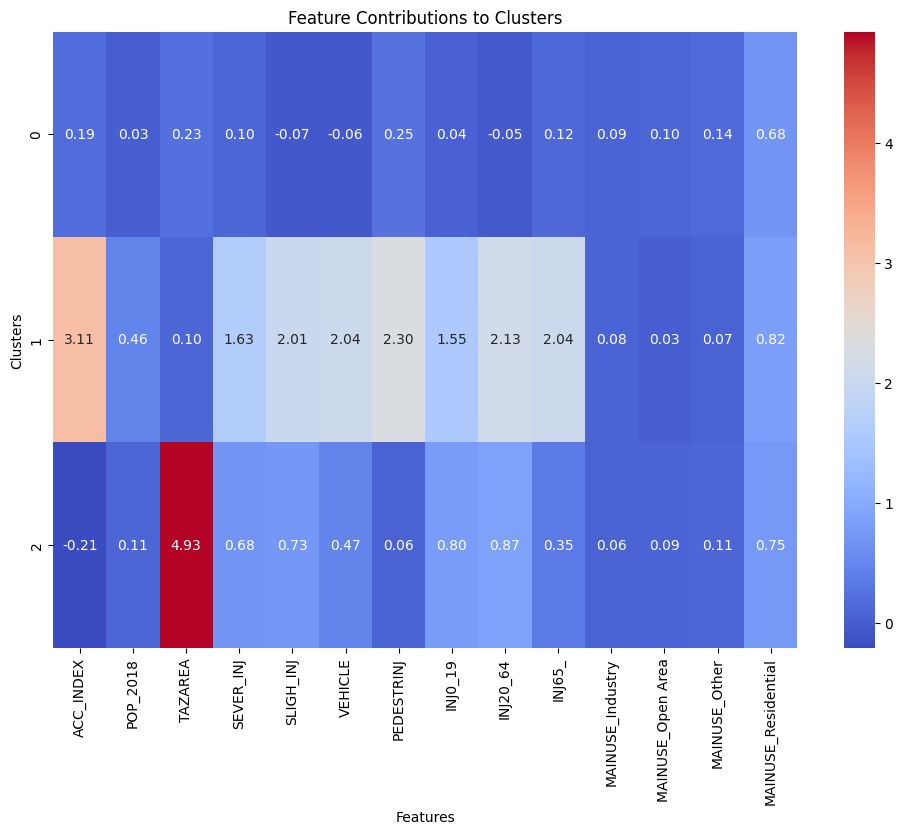

In [91]:
plot_feature_contributions(cluster_means)

## **Recommendations for Each Cluster**

### **Cluster 0: Balanced Residential Area**
- **Key Characteristics**:
  - Low accident index (**ACC_INDEX**: 0.19), indicating low accident density.
  - High proportion of residential areas (**MAINUSE_Residential**: 0.68).
  - Moderate pedestrian injuries (**PEDESTRINJ**: 0.24).
- **Recommendations**:
  - Continue regular monitoring of traffic safety to maintain current low-risk levels.
  - Consider implementing minor improvements in pedestrian safety, such as better crosswalk visibility and additional signage.

---

### **Cluster 1: High-Risk Urban Area**
- **Key Characteristics**:
  - High accident index (**ACC_INDEX**: 3.10), indicating a high density of accidents.
  - High number of slight injuries (**SLIGH_INJ**: 2.01) and severe injuries (**SEVER_INJ**: 1.63).
  - High vehicle involvement in accidents (**VEHICLE**: 2.04).
  - High number of pedestrian injuries (**PEDESTRINJ**: 2.30).
- **Recommendations**:
  - Implement strict traffic enforcement measures, such as speed cameras and increased police presence.
  - Improve road infrastructure by adding traffic calming measures (speed bumps, roundabouts) and enhancing street lighting.
  - Launch public awareness campaigns focused on road safety and accident prevention.
  - Consider increasing pedestrian safety through designated pedestrian zones and better crosswalks.

---

### **Cluster 2: Large Open-Area Region**
- **Key Characteristics**:
  - Large area coverage (**TAZAREA**: 4.92), indicating a wide, less densely populated region.
  - Moderate injury levels (**SEVER_INJ**: 0.68, **SLIGH_INJ**: 0.72).
  - High proportion of open areas (**MAINUSE_Open Area**: 0.08) and residential areas (**MAINUSE_Residential**: 0.75).
- **Recommendations**:
  - Focus on improving infrastructure for long-distance travel, such as maintaining and expanding roads in rural or open areas.
  - Enhance pedestrian safety by installing better lighting and crosswalks in residential zones.
  - Consider adding public transportation options to improve accessibility in this large area.
  - Encourage urban development in specific zones to reduce travel distances and increase safety.


## **Anomalies Analysis**

In [92]:
anomalies = detect_anomalies(data_pca, labels)
print("Anomalies detected:", anomalies)

Detected 38 anomalies across all clusters.
Anomalies detected: [(530, 1), (560, 1), (932, 1), (1327, 1), (1431, 1), (1531, 1), (1552, 1), (1637, 1), (1800, 1), (13, 0), (212, 0), (417, 0), (549, 0), (561, 0), (829, 0), (892, 0), (959, 0), (1027, 0), (1196, 0), (1223, 0), (1226, 0), (1306, 0), (1441, 0), (1622, 0), (1688, 0), (1694, 0), (1716, 0), (1722, 0), (1823, 0), (1943, 0), (1963, 0), (2251, 0), (2262, 0), (2269, 0), (2273, 0), (644, 2), (1462, 2), (1645, 2)]


In [93]:
summary = cluster_summary(data_pca, labels)

Cluster Summary:


Principal Component 1  Principal Component 2
Cluster                                              
0                    -1.011048              -0.574648
1                     4.875943              -0.517051
2                    -0.221458               4.279326

### Detected Anomalies and Distances to Cluster Centers

In [94]:
anomaly_table = create_anomaly_table(data_pca, labels, anomalies)
print("Anomalies detected:")
display(anomaly_table)


Anomalies detected:


Index  Cluster
0     530        1
1     560        1
2     932        1
3    1327        1
4    1431        1
5    1531        1
6    1552        1
7    1637        1
8    1800        1
9      13        0
10    212        0
11    417        0
12    549        0
13    561        0
14    829        0
15    892        0
16    959        0
17   1027        0
18   1196        0
19   1223        0
20   1226        0
21   1306        0
22   1441        0
23   1622        0
24   1688        0
25   1694        0
26   1716        0
27   1722        0
28   1823        0
29   1943        0
30   1963        0
31   2251        0
32   2262        0
33   2269        0
34   2273        0
35    644        2
36   1462        2
37   1645        2

In [95]:
cluster_centers = kmeans.cluster_centers_
anomaly_distances = calculate_anomaly_distances(data_pca, anomalies, cluster_centers)


Anomaly Distances to Cluster Centers:


Cluster 0  Cluster 1  Cluster 2
530   14.954164  10.541873  12.136768
560    8.638542   5.351434   6.026718
932    8.376188   5.292518   5.700962
1327  13.551571   8.799854  11.229914
1431  13.657077   9.406926  10.819260
1531  13.737129   7.908229  14.290068
1552  11.372966   7.500159   8.530045
1637   9.419778   5.872732   6.759307
1800  13.327210   8.784122  10.811987
13     2.609273   6.863584   2.633527
212    2.436315   6.292986   2.525898
417    2.473507   7.096923   3.004833
549    2.573103   7.373717   3.190004
561    2.382829   5.616900   2.584692
829    2.583231   6.822510   2.632989
892    2.407580   6.751436   2.785662
959    2.514755   7.191506   3.052757
1027   2.280645   6.018942   2.639781
1196   2.303939   6.704594   2.872516
1223   2.379974   6.533026   2.683036
1226   2.853916   7.501056   2.983155
1306   2.443552   5.806127   2.486723
1441   2.389983   6.110339   2.536987
1622   2.880573   7.504728   2.953272
1688   2.538611   6.938797   2.778246
1694   2.751048   7.311805   2.888203
1716   2.406619   7.099314   3.090385
1722   2.463477   7.228971   3.159658
1823   2.555679   7.058268   2.865806
1943   2.792451   7.624321   3.227769
1963   2.794751   7.625257   3.225961
2251   2.686603   7.581637   3.312127
2262   2.746415   7.605707   3.264241
2269   2.545975   7.353702   3.200806
2273   2.954689   7.679735   3.086990
644   10.851157   8.495452   6.976957
1462  10.647328   7.595879   7.290245
1645  12.276033  10.116165   8.104700

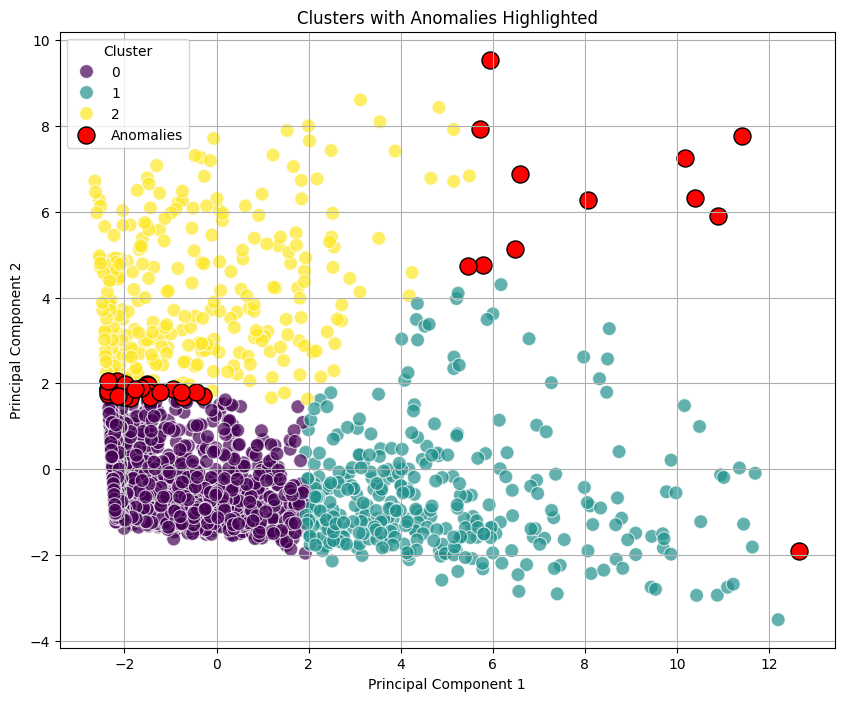

In [96]:
plot_clusters_with_anomalies(data_pca, labels, anomalies)

## **Final Conclusions**

This project aimed to build a recommendation system for improving traffic safety by analyzing accident data using unsupervised learning techniques. The key steps included clustering analysis, identifying high-risk areas, and detecting anomalies for focused investigation.

### **Cluster-Based Analysis**
Three distinct clusters were identified, each representing different types of regions based on their traffic and safety characteristics:
1. **Cluster 0 – Balanced Residential Area**:  
   Characterized by low accident density and a high proportion of residential zones. Recommendations included maintaining current safety levels through regular monitoring and minor pedestrian safety improvements.
   
2. **Cluster 1 – High-Risk Urban Area**:  
   Representing zones with high accident density, severe injuries, and high vehicle involvement. Recommendations focused on strict traffic enforcement, infrastructure improvements, and public safety campaigns.

3. **Cluster 2 – Large Open-Area Region**:  
   Consisting of large, less densely populated areas with moderate injury levels. Recommendations included improving long-distance travel infrastructure, enhancing pedestrian safety, and supporting urban development.

---

### **Anomalies Analysis**
A total of **38 anomalies** were detected across the clusters, representing specific cases with extreme or unusual characteristics:
- **Cluster 0**: 25 anomalies, likely due to temporary or local factors such as road construction or hazardous segments.  
- **Cluster 1**: 9 anomalies, indicating exceptionally high-risk zones within an already high-risk area.  
- **Cluster 2**: 4 anomalies, possibly related to unique geographic conditions or outdated infrastructure.

The anomalies highlighted cases where general recommendations may not be sufficient, and specific, localized acti..

### **Recommendations**
1. **Focused Investigations**:  
   Conduct detailed inspections in anomalous zones to understand specific causes of deviations, such as hazardous intersections or insufficient road safety measures.

2. **Short-Term Interventions**:  
   Implement temporary solutions, such as better signage, lighting, and speed restrictions in high-priority zones.

3. **Long-Term Monitoring**:  
   Establish a data-driven monitoring system to continuously track the effectiveness of the recommendations and detect future anomalies.
atthorities for practical implementation.
